# Digit Generation 🔢

![](https://images.unsplash.com/photo-1502570149819-b2260483d302?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80)

Photo by [Nick Hillier](https://unsplash.com/photos/yD5rv8_WzxA)

---

# A GAN to generate digits

In this exercise, you will be asked to :
- complete the code to create your first GAN
- train a GAN to generate digits based on the MNIST dataset

You should be able to generate new digits by the end of the exercise. This exercise can be run locally, but you can also go for a notebook in Google Colab for example.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from tensorflow.keras.datasets import mnist

## I. Input data

In this GAN example, we're going to use the MNIST dataset. MNIST is a set of handwritten digits. We'll try to generate new digit samples using GANs.

We kindly remind you how to load the data 🙂

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Some useful variables
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

11493376/11490434 [==============================] - 1s 0us/step


**Q1**. Rescale the data from -1 to 1 and format the X_train dataset in order to have the proper dimensions

> 🔦 **Hint**: Remember, the MNIST dataset is grayscale so contains only one channel but Keras expects input images to have 3 dimensions even if there is only one channel.

In [11]:
X_train_rs = 2*X_train.reshape(len(X_train),img_rows, img_cols, channels)/255-1

**Q2**.Visualize one of the image

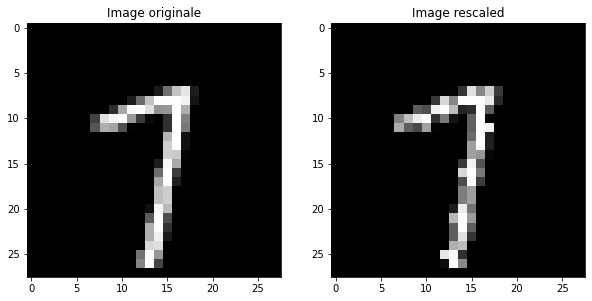

In [27]:
# TODO : Visualize one image
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(X_train[42].reshape(28,28), cmap='gray')
plt.title('Image originale')
plt.subplot(122)
plt.imshow(X_train_rs[42].reshape(28,28), cmap='gray')
plt.title('Image rescaled')
plt.show()

## II. Build the GAN

In [32]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

### a. The Generator

**Q1**. The first step is to build a generator. For the generator, we start with an **input noise shape of size 100**. We then create a sequential model to increase the size of the data up to 1024, before reshaping the data back to the input image shape.

Each layer will be made of:
- A **Dense layer** (sizes 256, 512, 1024 in order)
- A **LeakyRelu activation** with alpha = 0.2
- A **Batch normalization** (momentum = 0.8)

In [35]:
def build_generator():
    # Input Data
    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    
    # Create the sequential model
    model = Sequential()

    # Build the first layer
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Second layer
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Third layer
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    # Flatten and reshape
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    img = model(noise)

    # Get model summary
    model.summary()
    
    return Model(noise, img)

**Q2**. Compile the Generator and add an Adam optimizer as advised.

In [36]:
generator = build_generator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)             

In [56]:
from tensorflow.python.framework import ops
from tensorflow.python.ops.losses import losses

def minimax_generator_loss(
    discriminator_gen_outputs,
    label_smoothing=0.0,
    weights=1.0,
    scope=None,
    loss_collection=ops.GraphKeys.LOSSES,
    reduction=losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
    add_summaries=False):
  """Original minimax generator loss for GANs.
  Note that the authors don't recommend using this loss. A more practically
  useful loss is `modified_generator_loss`.
  L = log(sigmoid(D(x))) + log(1 - sigmoid(D(G(z))))
  See `Generative Adversarial Nets` (https://arxiv.org/abs/1406.2661) for more
  details.
  Args:
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
    label_smoothing: The amount of smoothing for positive labels. This technique
      is taken from `Improved Techniques for Training GANs`
      (https://arxiv.org/abs/1606.03498). `0.0` means no smoothing.
    weights: Optional `Tensor` whose rank is either 0, or the same rank as
      `discriminator_gen_outputs`, and must be broadcastable to
      `discriminator_gen_outputs` (i.e., all dimensions must be either `1`, or
      the same as the corresponding dimension).
    scope: The scope for the operations performed in computing the loss.
    loss_collection: collection to which this loss will be added.
    reduction: A `tf.losses.Reduction` to apply to loss.
    add_summaries: Whether or not to add summaries for the loss.
  Returns:
    A loss Tensor. The shape depends on `reduction`.
  """
  with ops.name_scope(scope, 'generator_minimax_loss') as scope:
    loss = - minimax_discriminator_loss(
        array_ops.ones_like(discriminator_gen_outputs),
        discriminator_gen_outputs, label_smoothing, weights, weights, scope,
        loss_collection, reduction, add_summaries=False)

  if add_summaries:
    summary.scalar('generator_minimax_loss', loss)

  return loss

In [59]:
# TODO : Compile the generator
generator.compile(optimizer='adam', loss=minimax_generator_loss)

### b. The Discriminator

**Q3**. Build the discriminator. It takes an input that has the shape of the image. The steps are the following :
- Declare the **Sequential** model
- **Flatten** the images (with input shape = image shape)
- Add a **Dense layer** of 512 and a **Leaky Relu** (0.2)
- Add a **Dense layer** of 256 and a **Leaky Relu** (0.2)
- Add a **Dense layer** of size 1. What activation function would you use ?

In [60]:
def build_discriminator():
    
    img = Input(shape=img_shape)

    # Create the sequential model
    model = Sequential()
    
    # Flatten the images taken as inputs
    model.add(Flatten())
    
    # First layer
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))

    
    # Second layer
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    # Last layer, return either 0 or 1
    model.add(Dense(1, activation='sigmoid'))
    
    # Get model summary
    validity = model(img)
    model.summary()
    
    return Model(img, validity)

**Q4**. Now compile the discriminator. (Observe the metric we are using)

In [61]:
discriminator = build_discriminator()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [62]:
# TODO: Compile the discriminator
discriminator.compile(optimizer='sgd', loss='binary_crossentropy', metrics='accuracy')

### c. Build the GAN model

**Q5**. Now it is time to build **the GAN model**. This is done in 4 major steps :
- Declare the input
- Set the image as the result of the generator of the input
- Set the output as the result of the discriminator of the generated image
- Define and compile the model

In [63]:
# 1. Declare input of size (100, )
noise_img = Input(shape=(100,))

# 2. Define the generated image from the input
# Hint : Use the generator model compiled above
generated_img = generator(noise_img)

# 3. Define the output from the image
# Hint : Use the discriminator model compiled above
output = discriminator(generated_img)

# For the combined model, only train the generator

# 4.Combined model
# Create the model by defining the input and the output
gan = Model(noise_img, output)
gan.layers[-1].trainable = False

# Once created, we compile the model

In [79]:
gan.compile(optimizer='adam', loss='binary_crossentropy')

**Q6**. Print the summary of the new model created. Comment on the shapes at each layer.

In [80]:
# TODO: Print model summary
gan.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_1 (Functional)    (None, 28, 28, 1)         1493520   
_________________________________________________________________
functional_9 (Functional)    (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


We then define a function that is used to save generated images once in a while.

In [81]:
def save_imgs(epoch):
    
    # Predict from input noise
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Subplots
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
 
    fig.savefig("images_gan/mnist_%d.png" % epoch)
    plt.close()

## III. Train the model

First of all, we set :
- the number of epochs the model will train to 15'000
- the batch size to 64
- the interval at which we save the images to 1000

In [82]:
epochs = 15000
batch_size = 64
save_interval = 1000
half_batch = int(batch_size / 2)

The following code is complete. Try to understand the different steps, debug potential errors from your previous code and compile it. 

In [83]:
# If the directory to save the images does not exist create it 
!mkdir images_gan

mkdir: impossible de créer le répertoire «images_gan»: Le fichier existe


In [84]:
import tensorflow as tf

In [85]:
d_loss_hist = []
g_loss_hist = []
d_acc = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Pick 50% of sample images
    idx = np.random.randint(0, X_train_rs.shape[0], half_batch)
    imgs = X_train_rs[idx]

    # Generate 50% of new images
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)
    
    
    # Train discriminator on real images with label 1
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    
    # Train discriminator on fake images with label 0
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    
    # Loss of discriminator = Mean of Real and Fake loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    d_loss_hist.append(d_loss[0])
    d_acc.append(d_loss[1])
    
    # ---------------------
    #  Train Generator
    # ---------------------

    # The generator wants the discriminator to label the generated samples as valid (ones)
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)
    g_loss_hist.append(g_loss)
    
    # Print the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
    if epoch % save_interval == 0:
        save_imgs(epoch)

0 [D loss: 0.269093, acc.: 100.00%] [G loss: 0.926043]
1 [D loss: 0.286920, acc.: 100.00%] [G loss: 0.807653]
2 [D loss: 0.344284, acc.: 82.81%] [G loss: 0.660443]
3 [D loss: 0.397281, acc.: 64.06%] [G loss: 0.574164]
4 [D loss: 0.456862, acc.: 54.69%] [G loss: 0.510966]
5 [D loss: 0.530917, acc.: 50.00%] [G loss: 0.448387]
6 [D loss: 0.569575, acc.: 50.00%] [G loss: 0.462229]
7 [D loss: 0.655115, acc.: 51.56%] [G loss: 0.441350]
8 [D loss: 0.647601, acc.: 51.56%] [G loss: 0.423078]
9 [D loss: 0.606119, acc.: 50.00%] [G loss: 0.465624]
10 [D loss: 0.622399, acc.: 53.12%] [G loss: 0.499804]
11 [D loss: 0.622885, acc.: 50.00%] [G loss: 0.595182]
12 [D loss: 0.558140, acc.: 54.69%] [G loss: 0.664632]
13 [D loss: 0.487452, acc.: 62.50%] [G loss: 0.732379]
14 [D loss: 0.463306, acc.: 65.62%] [G loss: 0.829417]
15 [D loss: 0.396130, acc.: 76.56%] [G loss: 0.933697]
16 [D loss: 0.354838, acc.: 82.81%] [G loss: 1.017938]
17 [D loss: 0.327204, acc.: 85.94%] [G loss: 1.057514]
18 [D loss: 0.2756

150 [D loss: 0.376094, acc.: 89.06%] [G loss: 1.875392]
151 [D loss: 0.490134, acc.: 79.69%] [G loss: 2.607867]
152 [D loss: 0.635114, acc.: 73.44%] [G loss: 1.745426]
153 [D loss: 0.483787, acc.: 78.12%] [G loss: 2.503647]
154 [D loss: 0.619862, acc.: 73.44%] [G loss: 2.128175]
155 [D loss: 0.535247, acc.: 78.12%] [G loss: 2.314360]
156 [D loss: 0.644741, acc.: 73.44%] [G loss: 2.308693]
157 [D loss: 0.522672, acc.: 79.69%] [G loss: 1.981257]
158 [D loss: 0.631218, acc.: 75.00%] [G loss: 2.252464]
159 [D loss: 0.742723, acc.: 64.06%] [G loss: 1.881984]
160 [D loss: 0.477846, acc.: 84.38%] [G loss: 1.993167]
161 [D loss: 0.659712, acc.: 73.44%] [G loss: 2.345663]
162 [D loss: 0.760438, acc.: 64.06%] [G loss: 1.850548]
163 [D loss: 0.566320, acc.: 79.69%] [G loss: 1.863179]
164 [D loss: 0.586233, acc.: 79.69%] [G loss: 2.023523]
165 [D loss: 0.442987, acc.: 85.94%] [G loss: 1.952029]
166 [D loss: 0.507679, acc.: 81.25%] [G loss: 2.238604]
167 [D loss: 0.504228, acc.: 82.81%] [G loss: 2.

297 [D loss: 0.537363, acc.: 75.00%] [G loss: 2.597652]
298 [D loss: 0.466688, acc.: 95.31%] [G loss: 2.620588]
299 [D loss: 0.419134, acc.: 98.44%] [G loss: 2.676476]
300 [D loss: 0.396813, acc.: 100.00%] [G loss: 2.683662]
301 [D loss: 0.427586, acc.: 96.88%] [G loss: 2.766922]
302 [D loss: 0.356575, acc.: 98.44%] [G loss: 2.764372]
303 [D loss: 0.378683, acc.: 96.88%] [G loss: 3.132332]
304 [D loss: 0.446597, acc.: 90.62%] [G loss: 2.868160]
305 [D loss: 0.307995, acc.: 100.00%] [G loss: 3.077559]
306 [D loss: 0.321696, acc.: 100.00%] [G loss: 2.704386]
307 [D loss: 0.306940, acc.: 100.00%] [G loss: 3.056467]
308 [D loss: 0.317344, acc.: 98.44%] [G loss: 2.955747]
309 [D loss: 0.280562, acc.: 98.44%] [G loss: 2.805216]
310 [D loss: 0.325112, acc.: 100.00%] [G loss: 3.108249]
311 [D loss: 0.367396, acc.: 96.88%] [G loss: 2.884062]
312 [D loss: 0.294865, acc.: 100.00%] [G loss: 3.223303]
313 [D loss: 0.390277, acc.: 96.88%] [G loss: 3.283160]
314 [D loss: 0.404821, acc.: 96.88%] [G lo

446 [D loss: 0.640390, acc.: 53.12%] [G loss: 1.807919]
447 [D loss: 0.625806, acc.: 56.25%] [G loss: 1.877047]
448 [D loss: 0.736533, acc.: 46.88%] [G loss: 1.848121]
449 [D loss: 0.646162, acc.: 53.12%] [G loss: 1.858832]
450 [D loss: 0.591170, acc.: 71.88%] [G loss: 2.026246]
451 [D loss: 0.631594, acc.: 60.94%] [G loss: 1.947237]
452 [D loss: 0.568752, acc.: 71.88%] [G loss: 2.096197]
453 [D loss: 0.610511, acc.: 68.75%] [G loss: 2.271376]
454 [D loss: 0.613616, acc.: 64.06%] [G loss: 2.044521]
455 [D loss: 0.573326, acc.: 76.56%] [G loss: 1.962128]
456 [D loss: 0.546392, acc.: 90.62%] [G loss: 2.239741]
457 [D loss: 0.576589, acc.: 84.38%] [G loss: 2.234059]
458 [D loss: 0.597854, acc.: 76.56%] [G loss: 2.104451]
459 [D loss: 0.504701, acc.: 89.06%] [G loss: 1.992653]
460 [D loss: 0.520566, acc.: 84.38%] [G loss: 2.219201]
461 [D loss: 0.536561, acc.: 85.94%] [G loss: 2.235567]
462 [D loss: 0.515825, acc.: 85.94%] [G loss: 2.133485]
463 [D loss: 0.561363, acc.: 75.00%] [G loss: 2.

594 [D loss: 0.545873, acc.: 75.00%] [G loss: 2.334320]
595 [D loss: 0.508709, acc.: 89.06%] [G loss: 2.491017]
596 [D loss: 0.482914, acc.: 92.19%] [G loss: 2.436651]
597 [D loss: 0.524000, acc.: 78.12%] [G loss: 2.348953]
598 [D loss: 0.534138, acc.: 81.25%] [G loss: 2.348589]
599 [D loss: 0.590880, acc.: 68.75%] [G loss: 2.457842]
600 [D loss: 0.560812, acc.: 81.25%] [G loss: 2.486346]
601 [D loss: 0.535504, acc.: 89.06%] [G loss: 2.314579]
602 [D loss: 0.614351, acc.: 76.56%] [G loss: 2.367150]
603 [D loss: 0.531202, acc.: 89.06%] [G loss: 2.653440]
604 [D loss: 0.660449, acc.: 54.69%] [G loss: 2.381249]
605 [D loss: 0.591607, acc.: 75.00%] [G loss: 2.321507]
606 [D loss: 0.512659, acc.: 89.06%] [G loss: 2.540934]
607 [D loss: 0.569069, acc.: 78.12%] [G loss: 2.445750]
608 [D loss: 0.566051, acc.: 75.00%] [G loss: 2.509903]
609 [D loss: 0.581248, acc.: 78.12%] [G loss: 2.370677]
610 [D loss: 0.668086, acc.: 56.25%] [G loss: 2.215650]
611 [D loss: 0.595678, acc.: 75.00%] [G loss: 2.

742 [D loss: 0.463602, acc.: 89.06%] [G loss: 2.773695]
743 [D loss: 0.528349, acc.: 75.00%] [G loss: 2.869865]
744 [D loss: 0.526201, acc.: 75.00%] [G loss: 2.618919]
745 [D loss: 0.484810, acc.: 87.50%] [G loss: 2.884415]
746 [D loss: 0.515341, acc.: 89.06%] [G loss: 3.073321]
747 [D loss: 0.583254, acc.: 79.69%] [G loss: 3.103655]
748 [D loss: 0.592233, acc.: 73.44%] [G loss: 2.712768]
749 [D loss: 0.434302, acc.: 95.31%] [G loss: 2.952291]
750 [D loss: 0.490841, acc.: 90.62%] [G loss: 2.802811]
751 [D loss: 0.526697, acc.: 90.62%] [G loss: 2.879356]
752 [D loss: 0.535807, acc.: 87.50%] [G loss: 3.088760]
753 [D loss: 0.544695, acc.: 85.94%] [G loss: 2.926269]
754 [D loss: 0.559273, acc.: 73.44%] [G loss: 2.945575]
755 [D loss: 0.543554, acc.: 82.81%] [G loss: 2.609660]
756 [D loss: 0.426982, acc.: 92.19%] [G loss: 3.266412]
757 [D loss: 0.474324, acc.: 92.19%] [G loss: 3.265154]
758 [D loss: 0.596406, acc.: 68.75%] [G loss: 2.923360]
759 [D loss: 0.394220, acc.: 98.44%] [G loss: 3.

889 [D loss: 0.534179, acc.: 79.69%] [G loss: 3.697904]
890 [D loss: 0.411192, acc.: 90.62%] [G loss: 3.461225]
891 [D loss: 0.393931, acc.: 93.75%] [G loss: 3.780676]
892 [D loss: 0.415764, acc.: 92.19%] [G loss: 3.561769]
893 [D loss: 0.333111, acc.: 96.88%] [G loss: 3.428010]
894 [D loss: 0.416687, acc.: 85.94%] [G loss: 3.776111]
895 [D loss: 0.410911, acc.: 93.75%] [G loss: 3.598593]
896 [D loss: 0.490144, acc.: 84.38%] [G loss: 3.996772]
897 [D loss: 0.475030, acc.: 90.62%] [G loss: 4.293462]
898 [D loss: 0.672639, acc.: 53.12%] [G loss: 4.033066]
899 [D loss: 0.566674, acc.: 73.44%] [G loss: 3.506575]
900 [D loss: 0.378478, acc.: 92.19%] [G loss: 3.854090]
901 [D loss: 0.355525, acc.: 98.44%] [G loss: 3.702663]
902 [D loss: 0.409076, acc.: 89.06%] [G loss: 3.686506]
903 [D loss: 0.514852, acc.: 79.69%] [G loss: 4.352496]
904 [D loss: 0.474320, acc.: 87.50%] [G loss: 3.799869]
905 [D loss: 0.570751, acc.: 71.88%] [G loss: 3.972466]
906 [D loss: 0.626613, acc.: 64.06%] [G loss: 3.

1037 [D loss: 0.484667, acc.: 87.50%] [G loss: 3.507472]
1038 [D loss: 0.713567, acc.: 56.25%] [G loss: 3.278177]
1039 [D loss: 0.541562, acc.: 79.69%] [G loss: 3.440548]
1040 [D loss: 0.560841, acc.: 78.12%] [G loss: 3.108843]
1041 [D loss: 0.621598, acc.: 68.75%] [G loss: 2.944573]
1042 [D loss: 0.599551, acc.: 67.19%] [G loss: 3.212990]
1043 [D loss: 0.657584, acc.: 60.94%] [G loss: 3.183167]
1044 [D loss: 0.703164, acc.: 56.25%] [G loss: 2.768103]
1045 [D loss: 0.571767, acc.: 65.62%] [G loss: 2.941767]
1046 [D loss: 0.587867, acc.: 64.06%] [G loss: 2.901047]
1047 [D loss: 0.594207, acc.: 60.94%] [G loss: 3.244475]
1048 [D loss: 0.776866, acc.: 45.31%] [G loss: 2.731896]
1049 [D loss: 0.502387, acc.: 81.25%] [G loss: 3.045703]
1050 [D loss: 0.719461, acc.: 48.44%] [G loss: 2.927887]
1051 [D loss: 0.795117, acc.: 45.31%] [G loss: 2.708793]
1052 [D loss: 0.690192, acc.: 53.12%] [G loss: 2.906526]
1053 [D loss: 0.543954, acc.: 73.44%] [G loss: 2.702975]
1054 [D loss: 0.648145, acc.: 6

1182 [D loss: 0.759307, acc.: 35.94%] [G loss: 1.528316]
1183 [D loss: 0.625248, acc.: 64.06%] [G loss: 1.545457]
1184 [D loss: 0.766174, acc.: 37.50%] [G loss: 1.486255]
1185 [D loss: 0.668262, acc.: 50.00%] [G loss: 1.600072]
1186 [D loss: 0.724736, acc.: 39.06%] [G loss: 1.515737]
1187 [D loss: 0.690792, acc.: 50.00%] [G loss: 1.582366]
1188 [D loss: 0.688594, acc.: 45.31%] [G loss: 1.560946]
1189 [D loss: 0.792071, acc.: 37.50%] [G loss: 1.384290]
1190 [D loss: 0.745627, acc.: 39.06%] [G loss: 1.280307]
1191 [D loss: 0.681094, acc.: 53.12%] [G loss: 1.350534]
1192 [D loss: 0.773470, acc.: 37.50%] [G loss: 1.322139]
1193 [D loss: 0.724419, acc.: 40.62%] [G loss: 1.324348]
1194 [D loss: 0.772147, acc.: 43.75%] [G loss: 1.315923]
1195 [D loss: 0.776228, acc.: 40.62%] [G loss: 1.412817]
1196 [D loss: 0.786417, acc.: 31.25%] [G loss: 1.417523]
1197 [D loss: 0.781508, acc.: 29.69%] [G loss: 1.343357]
1198 [D loss: 0.727183, acc.: 40.62%] [G loss: 1.819890]
1199 [D loss: 0.731754, acc.: 4

1326 [D loss: 0.714201, acc.: 42.19%] [G loss: 0.886590]
1327 [D loss: 0.723430, acc.: 39.06%] [G loss: 0.880499]
1328 [D loss: 0.722675, acc.: 46.88%] [G loss: 0.862871]
1329 [D loss: 0.683200, acc.: 43.75%] [G loss: 1.158045]
1330 [D loss: 0.696142, acc.: 46.88%] [G loss: 0.866871]
1331 [D loss: 0.692027, acc.: 45.31%] [G loss: 0.901741]
1332 [D loss: 0.721116, acc.: 43.75%] [G loss: 0.892198]
1333 [D loss: 0.703127, acc.: 46.88%] [G loss: 0.876899]
1334 [D loss: 0.702398, acc.: 43.75%] [G loss: 0.890999]
1335 [D loss: 0.705964, acc.: 46.88%] [G loss: 0.889870]
1336 [D loss: 0.670534, acc.: 59.38%] [G loss: 0.906735]
1337 [D loss: 0.705096, acc.: 39.06%] [G loss: 0.885126]
1338 [D loss: 0.714058, acc.: 42.19%] [G loss: 0.890594]
1339 [D loss: 0.702452, acc.: 45.31%] [G loss: 0.879079]
1340 [D loss: 0.709767, acc.: 39.06%] [G loss: 0.884807]
1341 [D loss: 0.729335, acc.: 40.62%] [G loss: 0.866875]
1342 [D loss: 0.710016, acc.: 45.31%] [G loss: 0.845738]
1343 [D loss: 0.698630, acc.: 4

1471 [D loss: 0.723388, acc.: 39.06%] [G loss: 0.800764]
1472 [D loss: 0.728536, acc.: 48.44%] [G loss: 0.776613]
1473 [D loss: 0.682643, acc.: 50.00%] [G loss: 0.774452]
1474 [D loss: 0.703378, acc.: 40.62%] [G loss: 0.766292]
1475 [D loss: 0.707437, acc.: 46.88%] [G loss: 0.765146]
1476 [D loss: 0.709938, acc.: 45.31%] [G loss: 0.893519]
1477 [D loss: 0.704693, acc.: 43.75%] [G loss: 0.776378]
1478 [D loss: 0.719783, acc.: 45.31%] [G loss: 0.793332]
1479 [D loss: 0.700389, acc.: 50.00%] [G loss: 0.783765]
1480 [D loss: 0.706729, acc.: 45.31%] [G loss: 0.846293]
1481 [D loss: 0.712226, acc.: 39.06%] [G loss: 0.791285]
1482 [D loss: 0.722227, acc.: 31.25%] [G loss: 0.790544]
1483 [D loss: 0.700169, acc.: 35.94%] [G loss: 0.805367]
1484 [D loss: 0.719044, acc.: 34.38%] [G loss: 0.844548]
1485 [D loss: 0.697426, acc.: 42.19%] [G loss: 0.797292]
1486 [D loss: 0.712236, acc.: 32.81%] [G loss: 0.785065]
1487 [D loss: 0.717657, acc.: 39.06%] [G loss: 0.761626]
1488 [D loss: 0.698533, acc.: 4

1615 [D loss: 0.681465, acc.: 54.69%] [G loss: 0.773362]
1616 [D loss: 0.702446, acc.: 39.06%] [G loss: 0.787056]
1617 [D loss: 0.694592, acc.: 45.31%] [G loss: 0.770897]
1618 [D loss: 0.694867, acc.: 45.31%] [G loss: 0.819228]
1619 [D loss: 0.697456, acc.: 40.62%] [G loss: 0.800611]
1620 [D loss: 0.703685, acc.: 42.19%] [G loss: 0.735959]
1621 [D loss: 0.694312, acc.: 46.88%] [G loss: 0.742674]
1622 [D loss: 0.696289, acc.: 45.31%] [G loss: 0.779660]
1623 [D loss: 0.701701, acc.: 46.88%] [G loss: 0.764470]
1624 [D loss: 0.697161, acc.: 45.31%] [G loss: 0.791348]
1625 [D loss: 0.705016, acc.: 39.06%] [G loss: 0.803862]
1626 [D loss: 0.703995, acc.: 32.81%] [G loss: 0.806745]
1627 [D loss: 0.690547, acc.: 40.62%] [G loss: 0.806574]
1628 [D loss: 0.704205, acc.: 35.94%] [G loss: 0.770127]
1629 [D loss: 0.703771, acc.: 39.06%] [G loss: 0.791410]
1630 [D loss: 0.708995, acc.: 35.94%] [G loss: 0.784151]
1631 [D loss: 0.693991, acc.: 39.06%] [G loss: 0.799295]
1632 [D loss: 0.711059, acc.: 3

1759 [D loss: 0.716231, acc.: 29.69%] [G loss: 0.737554]
1760 [D loss: 0.712986, acc.: 31.25%] [G loss: 0.763839]
1761 [D loss: 0.713618, acc.: 32.81%] [G loss: 0.747459]
1762 [D loss: 0.710975, acc.: 25.00%] [G loss: 0.779681]
1763 [D loss: 0.719810, acc.: 28.12%] [G loss: 0.771100]
1764 [D loss: 0.715646, acc.: 18.75%] [G loss: 0.773330]
1765 [D loss: 0.716325, acc.: 18.75%] [G loss: 0.762912]
1766 [D loss: 0.709776, acc.: 23.44%] [G loss: 0.766245]
1767 [D loss: 0.716974, acc.: 21.88%] [G loss: 0.768840]
1768 [D loss: 0.708614, acc.: 23.44%] [G loss: 0.797829]
1769 [D loss: 0.701545, acc.: 29.69%] [G loss: 0.772589]
1770 [D loss: 0.696415, acc.: 31.25%] [G loss: 0.774084]
1771 [D loss: 0.722785, acc.: 23.44%] [G loss: 0.770340]
1772 [D loss: 0.718172, acc.: 35.94%] [G loss: 0.766934]
1773 [D loss: 0.706783, acc.: 32.81%] [G loss: 0.768199]
1774 [D loss: 0.705227, acc.: 40.62%] [G loss: 0.770076]
1775 [D loss: 0.707458, acc.: 23.44%] [G loss: 0.770902]
1776 [D loss: 0.703785, acc.: 3

1904 [D loss: 0.719148, acc.: 43.75%] [G loss: 0.740327]
1905 [D loss: 0.696039, acc.: 48.44%] [G loss: 0.749382]
1906 [D loss: 0.693021, acc.: 50.00%] [G loss: 0.738538]
1907 [D loss: 0.697994, acc.: 50.00%] [G loss: 0.799564]
1908 [D loss: 0.699728, acc.: 50.00%] [G loss: 0.734228]
1909 [D loss: 0.701944, acc.: 46.88%] [G loss: 0.767854]
1910 [D loss: 0.699210, acc.: 50.00%] [G loss: 0.766381]
1911 [D loss: 0.698778, acc.: 46.88%] [G loss: 0.751859]
1912 [D loss: 0.685222, acc.: 50.00%] [G loss: 0.744640]
1913 [D loss: 0.700944, acc.: 43.75%] [G loss: 0.786913]
1914 [D loss: 0.708607, acc.: 40.62%] [G loss: 0.767848]
1915 [D loss: 0.708764, acc.: 39.06%] [G loss: 0.730913]
1916 [D loss: 0.683873, acc.: 54.69%] [G loss: 0.783112]
1917 [D loss: 0.684676, acc.: 39.06%] [G loss: 0.798318]
1918 [D loss: 0.704175, acc.: 39.06%] [G loss: 0.787999]
1919 [D loss: 0.690732, acc.: 39.06%] [G loss: 0.842928]
1920 [D loss: 0.698660, acc.: 42.19%] [G loss: 0.831658]
1921 [D loss: 0.706282, acc.: 3

2048 [D loss: 0.698549, acc.: 42.19%] [G loss: 0.765653]
2049 [D loss: 0.708728, acc.: 32.81%] [G loss: 0.760946]
2050 [D loss: 0.703025, acc.: 34.38%] [G loss: 1.542022]
2051 [D loss: 0.699958, acc.: 46.88%] [G loss: 0.758021]
2052 [D loss: 0.708961, acc.: 37.50%] [G loss: 0.749620]
2053 [D loss: 0.715083, acc.: 29.69%] [G loss: 0.710741]
2054 [D loss: 0.714126, acc.: 29.69%] [G loss: 0.748903]
2055 [D loss: 0.708148, acc.: 40.62%] [G loss: 0.736225]
2056 [D loss: 0.715249, acc.: 28.12%] [G loss: 0.750144]
2057 [D loss: 0.705953, acc.: 35.94%] [G loss: 0.773517]
2058 [D loss: 0.704366, acc.: 35.94%] [G loss: 0.954106]
2059 [D loss: 0.712651, acc.: 26.56%] [G loss: 0.764244]
2060 [D loss: 0.697887, acc.: 39.06%] [G loss: 0.824877]
2061 [D loss: 0.698194, acc.: 37.50%] [G loss: 0.781885]
2062 [D loss: 0.703459, acc.: 26.56%] [G loss: 0.766209]
2063 [D loss: 0.683834, acc.: 43.75%] [G loss: 0.752645]
2064 [D loss: 0.699788, acc.: 45.31%] [G loss: 0.870728]
2065 [D loss: 0.697853, acc.: 3

2193 [D loss: 0.703147, acc.: 17.19%] [G loss: 0.759466]
2194 [D loss: 0.674552, acc.: 42.19%] [G loss: 0.783443]
2195 [D loss: 0.700958, acc.: 28.12%] [G loss: 0.788987]
2196 [D loss: 0.706369, acc.: 18.75%] [G loss: 0.783593]
2197 [D loss: 0.678622, acc.: 31.25%] [G loss: 0.799112]
2198 [D loss: 0.696128, acc.: 26.56%] [G loss: 0.788758]
2199 [D loss: 0.706552, acc.: 26.56%] [G loss: 0.783133]
2200 [D loss: 0.685380, acc.: 31.25%] [G loss: 0.784121]
2201 [D loss: 0.693865, acc.: 29.69%] [G loss: 0.778428]
2202 [D loss: 0.689284, acc.: 29.69%] [G loss: 0.778262]
2203 [D loss: 0.691598, acc.: 29.69%] [G loss: 0.768147]
2204 [D loss: 0.695933, acc.: 34.38%] [G loss: 0.770641]
2205 [D loss: 0.705382, acc.: 29.69%] [G loss: 0.765857]
2206 [D loss: 0.694203, acc.: 35.94%] [G loss: 0.779240]
2207 [D loss: 0.689202, acc.: 43.75%] [G loss: 0.773195]
2208 [D loss: 0.685795, acc.: 35.94%] [G loss: 0.784629]
2209 [D loss: 0.692775, acc.: 32.81%] [G loss: 0.781731]
2210 [D loss: 0.709040, acc.: 2

2339 [D loss: 0.692945, acc.: 50.00%] [G loss: 0.758806]
2340 [D loss: 0.691285, acc.: 56.25%] [G loss: 0.786062]
2341 [D loss: 0.689978, acc.: 53.12%] [G loss: 0.771374]
2342 [D loss: 0.687740, acc.: 54.69%] [G loss: 0.767713]
2343 [D loss: 0.686960, acc.: 51.56%] [G loss: 0.789401]
2344 [D loss: 0.702583, acc.: 39.06%] [G loss: 0.789433]
2345 [D loss: 0.688669, acc.: 40.62%] [G loss: 0.758073]
2346 [D loss: 0.703280, acc.: 37.50%] [G loss: 0.790190]
2347 [D loss: 0.708195, acc.: 28.12%] [G loss: 0.782288]
2348 [D loss: 0.694881, acc.: 37.50%] [G loss: 0.802888]
2349 [D loss: 0.700805, acc.: 29.69%] [G loss: 0.776412]
2350 [D loss: 0.702770, acc.: 28.12%] [G loss: 0.781533]
2351 [D loss: 0.703727, acc.: 35.94%] [G loss: 0.791776]
2352 [D loss: 0.700200, acc.: 39.06%] [G loss: 0.780602]
2353 [D loss: 0.704841, acc.: 32.81%] [G loss: 0.753966]
2354 [D loss: 0.706389, acc.: 42.19%] [G loss: 0.777295]
2355 [D loss: 0.691359, acc.: 40.62%] [G loss: 0.780817]
2356 [D loss: 0.699564, acc.: 4

2483 [D loss: 0.689757, acc.: 54.69%] [G loss: 0.754494]
2484 [D loss: 0.690937, acc.: 48.44%] [G loss: 0.728144]
2485 [D loss: 0.690649, acc.: 46.88%] [G loss: 0.721144]
2486 [D loss: 0.700718, acc.: 50.00%] [G loss: 0.770568]
2487 [D loss: 0.693123, acc.: 46.88%] [G loss: 0.750080]
2488 [D loss: 0.693480, acc.: 43.75%] [G loss: 0.773247]
2489 [D loss: 0.702145, acc.: 45.31%] [G loss: 0.758674]
2490 [D loss: 0.698936, acc.: 42.19%] [G loss: 0.838805]
2491 [D loss: 0.692766, acc.: 40.62%] [G loss: 0.741464]
2492 [D loss: 0.688853, acc.: 42.19%] [G loss: 0.750914]
2493 [D loss: 0.705666, acc.: 40.62%] [G loss: 0.750680]
2494 [D loss: 0.695999, acc.: 35.94%] [G loss: 0.790147]
2495 [D loss: 0.710572, acc.: 28.12%] [G loss: 0.770647]
2496 [D loss: 0.705286, acc.: 29.69%] [G loss: 0.800816]
2497 [D loss: 0.688848, acc.: 35.94%] [G loss: 0.788264]
2498 [D loss: 0.701896, acc.: 35.94%] [G loss: 0.793153]
2499 [D loss: 0.706581, acc.: 31.25%] [G loss: 0.779335]
2500 [D loss: 0.697263, acc.: 3

2628 [D loss: 0.692772, acc.: 48.44%] [G loss: 0.744267]
2629 [D loss: 0.691186, acc.: 46.88%] [G loss: 0.771822]
2630 [D loss: 0.699378, acc.: 43.75%] [G loss: 1.073047]
2631 [D loss: 0.699503, acc.: 48.44%] [G loss: 0.771636]
2632 [D loss: 0.700281, acc.: 43.75%] [G loss: 0.769698]
2633 [D loss: 0.693658, acc.: 37.50%] [G loss: 0.777991]
2634 [D loss: 0.695773, acc.: 42.19%] [G loss: 0.789085]
2635 [D loss: 0.697611, acc.: 25.00%] [G loss: 0.799429]
2636 [D loss: 0.707638, acc.: 29.69%] [G loss: 0.848901]
2637 [D loss: 0.704263, acc.: 23.44%] [G loss: 0.813300]
2638 [D loss: 0.704568, acc.: 29.69%] [G loss: 0.769550]
2639 [D loss: 0.700232, acc.: 31.25%] [G loss: 0.788764]
2640 [D loss: 0.715238, acc.: 15.62%] [G loss: 0.795122]
2641 [D loss: 0.708232, acc.: 20.31%] [G loss: 0.799128]
2642 [D loss: 0.706422, acc.: 17.19%] [G loss: 0.801022]
2643 [D loss: 0.688542, acc.: 29.69%] [G loss: 0.813015]
2644 [D loss: 0.689676, acc.: 23.44%] [G loss: 0.818557]
2645 [D loss: 0.719409, acc.: 2

2772 [D loss: 0.680930, acc.: 39.06%] [G loss: 0.810457]
2773 [D loss: 0.718088, acc.: 29.69%] [G loss: 0.764337]
2774 [D loss: 0.683913, acc.: 46.88%] [G loss: 0.784167]
2775 [D loss: 0.689058, acc.: 48.44%] [G loss: 0.759682]
2776 [D loss: 0.705042, acc.: 43.75%] [G loss: 0.765296]
2777 [D loss: 0.695200, acc.: 40.62%] [G loss: 0.781929]
2778 [D loss: 0.698358, acc.: 34.38%] [G loss: 0.769998]
2779 [D loss: 0.699428, acc.: 37.50%] [G loss: 0.788410]
2780 [D loss: 0.721554, acc.: 26.56%] [G loss: 0.779437]
2781 [D loss: 0.713437, acc.: 25.00%] [G loss: 0.805162]
2782 [D loss: 0.700187, acc.: 35.94%] [G loss: 0.776539]
2783 [D loss: 0.706989, acc.: 25.00%] [G loss: 0.770563]
2784 [D loss: 0.707541, acc.: 31.25%] [G loss: 0.771446]
2785 [D loss: 0.710131, acc.: 25.00%] [G loss: 0.771529]
2786 [D loss: 0.695805, acc.: 32.81%] [G loss: 0.777270]
2787 [D loss: 0.693330, acc.: 29.69%] [G loss: 0.802148]
2788 [D loss: 0.694086, acc.: 25.00%] [G loss: 0.799927]
2789 [D loss: 0.701983, acc.: 1

2917 [D loss: 0.697410, acc.: 29.69%] [G loss: 0.797283]
2918 [D loss: 0.710640, acc.: 26.56%] [G loss: 0.790148]
2919 [D loss: 0.695784, acc.: 31.25%] [G loss: 0.788825]
2920 [D loss: 0.689740, acc.: 50.00%] [G loss: 0.774207]
2921 [D loss: 0.707188, acc.: 37.50%] [G loss: 0.748984]
2922 [D loss: 0.717287, acc.: 34.38%] [G loss: 0.767443]
2923 [D loss: 0.701645, acc.: 37.50%] [G loss: 0.755148]
2924 [D loss: 0.705825, acc.: 35.94%] [G loss: 0.767510]
2925 [D loss: 0.691924, acc.: 48.44%] [G loss: 0.771635]
2926 [D loss: 0.685065, acc.: 42.19%] [G loss: 0.787623]
2927 [D loss: 0.707929, acc.: 34.38%] [G loss: 0.776400]
2928 [D loss: 0.687091, acc.: 39.06%] [G loss: 0.783028]
2929 [D loss: 0.700610, acc.: 34.38%] [G loss: 0.792437]
2930 [D loss: 0.692196, acc.: 40.62%] [G loss: 0.780641]
2931 [D loss: 0.699546, acc.: 40.62%] [G loss: 0.768880]
2932 [D loss: 0.705384, acc.: 26.56%] [G loss: 0.806485]
2933 [D loss: 0.699760, acc.: 31.25%] [G loss: 0.781783]
2934 [D loss: 0.696140, acc.: 2

3063 [D loss: 0.710717, acc.: 29.69%] [G loss: 0.797977]
3064 [D loss: 0.726092, acc.: 25.00%] [G loss: 0.778648]
3065 [D loss: 0.705111, acc.: 20.31%] [G loss: 0.778532]
3066 [D loss: 0.713608, acc.: 21.88%] [G loss: 0.782613]
3067 [D loss: 0.718562, acc.: 15.62%] [G loss: 0.841693]
3068 [D loss: 0.708896, acc.: 15.62%] [G loss: 0.795973]
3069 [D loss: 0.714941, acc.: 17.19%] [G loss: 0.767468]
3070 [D loss: 0.695644, acc.: 25.00%] [G loss: 0.823873]
3071 [D loss: 0.730220, acc.: 7.81%] [G loss: 0.779913]
3072 [D loss: 0.729357, acc.: 14.06%] [G loss: 0.768479]
3073 [D loss: 0.709650, acc.: 23.44%] [G loss: 0.761938]
3074 [D loss: 0.713691, acc.: 25.00%] [G loss: 0.754672]
3075 [D loss: 0.716468, acc.: 21.88%] [G loss: 0.762829]
3076 [D loss: 0.716155, acc.: 26.56%] [G loss: 0.751628]
3077 [D loss: 0.701141, acc.: 34.38%] [G loss: 0.738965]
3078 [D loss: 0.715922, acc.: 31.25%] [G loss: 0.735867]
3079 [D loss: 0.709825, acc.: 31.25%] [G loss: 0.713661]
3080 [D loss: 0.705287, acc.: 35

3208 [D loss: 0.718118, acc.: 18.75%] [G loss: 0.758327]
3209 [D loss: 0.700680, acc.: 28.12%] [G loss: 0.735777]
3210 [D loss: 0.713641, acc.: 23.44%] [G loss: 0.755210]
3211 [D loss: 0.700288, acc.: 34.38%] [G loss: 0.769229]
3212 [D loss: 0.689251, acc.: 26.56%] [G loss: 0.767211]
3213 [D loss: 0.705807, acc.: 23.44%] [G loss: 0.776440]
3214 [D loss: 0.699139, acc.: 34.38%] [G loss: 0.762134]
3215 [D loss: 0.706721, acc.: 29.69%] [G loss: 0.770187]
3216 [D loss: 0.687231, acc.: 42.19%] [G loss: 0.795839]
3217 [D loss: 0.707383, acc.: 35.94%] [G loss: 0.762991]
3218 [D loss: 0.709889, acc.: 29.69%] [G loss: 0.754987]
3219 [D loss: 0.705974, acc.: 37.50%] [G loss: 0.752311]
3220 [D loss: 0.699070, acc.: 43.75%] [G loss: 0.765214]
3221 [D loss: 0.705800, acc.: 37.50%] [G loss: 0.762277]
3222 [D loss: 0.692949, acc.: 43.75%] [G loss: 0.805060]
3223 [D loss: 0.687112, acc.: 45.31%] [G loss: 0.774545]
3224 [D loss: 0.693207, acc.: 43.75%] [G loss: 0.753853]
3225 [D loss: 0.700504, acc.: 3

3354 [D loss: 0.704240, acc.: 23.44%] [G loss: 0.765516]
3355 [D loss: 0.689363, acc.: 39.06%] [G loss: 0.792151]
3356 [D loss: 0.682748, acc.: 28.12%] [G loss: 0.843309]
3357 [D loss: 0.720356, acc.: 20.31%] [G loss: 0.805731]
3358 [D loss: 0.703181, acc.: 21.88%] [G loss: 0.798574]
3359 [D loss: 0.698749, acc.: 21.88%] [G loss: 0.784912]
3360 [D loss: 0.692152, acc.: 18.75%] [G loss: 0.794810]
3361 [D loss: 0.694834, acc.: 20.31%] [G loss: 0.811440]
3362 [D loss: 0.710212, acc.: 12.50%] [G loss: 0.776325]
3363 [D loss: 0.714801, acc.: 9.38%] [G loss: 0.778113]
3364 [D loss: 0.706112, acc.: 9.38%] [G loss: 0.780203]
3365 [D loss: 0.713947, acc.: 9.38%] [G loss: 0.793772]
3366 [D loss: 0.691779, acc.: 21.88%] [G loss: 0.803693]
3367 [D loss: 0.711571, acc.: 23.44%] [G loss: 0.805274]
3368 [D loss: 0.705867, acc.: 21.88%] [G loss: 0.795792]
3369 [D loss: 0.693413, acc.: 29.69%] [G loss: 0.803747]
3370 [D loss: 0.703928, acc.: 35.94%] [G loss: 0.807994]
3371 [D loss: 0.698702, acc.: 28.1

3498 [D loss: 0.692563, acc.: 43.75%] [G loss: 0.804121]
3499 [D loss: 0.675475, acc.: 48.44%] [G loss: 0.774882]
3500 [D loss: 0.693476, acc.: 43.75%] [G loss: 0.789203]
3501 [D loss: 0.684666, acc.: 51.56%] [G loss: 0.750647]
3502 [D loss: 0.673887, acc.: 51.56%] [G loss: 0.836157]
3503 [D loss: 0.689553, acc.: 35.94%] [G loss: 0.820744]
3504 [D loss: 0.683147, acc.: 54.69%] [G loss: 0.829343]
3505 [D loss: 0.668821, acc.: 59.38%] [G loss: 0.804775]
3506 [D loss: 0.688368, acc.: 51.56%] [G loss: 0.831799]
3507 [D loss: 0.690825, acc.: 40.62%] [G loss: 0.803813]
3508 [D loss: 0.688930, acc.: 48.44%] [G loss: 0.801528]
3509 [D loss: 0.683232, acc.: 43.75%] [G loss: 0.784083]
3510 [D loss: 0.694782, acc.: 39.06%] [G loss: 0.825830]
3511 [D loss: 0.667335, acc.: 53.12%] [G loss: 0.770242]
3512 [D loss: 0.702825, acc.: 31.25%] [G loss: 0.799753]
3513 [D loss: 0.708404, acc.: 17.19%] [G loss: 0.784463]
3514 [D loss: 0.709573, acc.: 25.00%] [G loss: 0.782667]
3515 [D loss: 0.712919, acc.: 1

3642 [D loss: 0.683022, acc.: 62.50%] [G loss: 0.787959]
3643 [D loss: 0.698629, acc.: 46.88%] [G loss: 0.791344]
3644 [D loss: 0.702215, acc.: 48.44%] [G loss: 0.800962]
3645 [D loss: 0.687940, acc.: 53.12%] [G loss: 0.752374]
3646 [D loss: 0.697739, acc.: 43.75%] [G loss: 0.738535]
3647 [D loss: 0.709527, acc.: 31.25%] [G loss: 0.770263]
3648 [D loss: 0.705775, acc.: 46.88%] [G loss: 0.764349]
3649 [D loss: 0.698629, acc.: 46.88%] [G loss: 0.765031]
3650 [D loss: 0.701615, acc.: 42.19%] [G loss: 0.779918]
3651 [D loss: 0.698538, acc.: 42.19%] [G loss: 0.799557]
3652 [D loss: 0.698600, acc.: 37.50%] [G loss: 0.774471]
3653 [D loss: 0.692425, acc.: 34.38%] [G loss: 0.751677]
3654 [D loss: 0.703344, acc.: 32.81%] [G loss: 0.764375]
3655 [D loss: 0.713403, acc.: 23.44%] [G loss: 0.790045]
3656 [D loss: 0.706463, acc.: 20.31%] [G loss: 0.794825]
3657 [D loss: 0.709012, acc.: 15.62%] [G loss: 0.857086]
3658 [D loss: 0.710300, acc.: 29.69%] [G loss: 0.814763]
3659 [D loss: 0.716197, acc.: 1

3786 [D loss: 0.710841, acc.: 23.44%] [G loss: 0.745032]
3787 [D loss: 0.692134, acc.: 45.31%] [G loss: 0.722552]
3788 [D loss: 0.722773, acc.: 28.12%] [G loss: 0.755522]
3789 [D loss: 0.715144, acc.: 29.69%] [G loss: 0.753347]
3790 [D loss: 0.713232, acc.: 26.56%] [G loss: 0.787366]
3791 [D loss: 0.699926, acc.: 29.69%] [G loss: 0.783514]
3792 [D loss: 0.695682, acc.: 29.69%] [G loss: 0.795233]
3793 [D loss: 0.715712, acc.: 21.88%] [G loss: 0.812532]
3794 [D loss: 0.712415, acc.: 18.75%] [G loss: 0.836129]
3795 [D loss: 0.700350, acc.: 37.50%] [G loss: 0.846400]
3796 [D loss: 0.713624, acc.: 17.19%] [G loss: 0.823083]
3797 [D loss: 0.704905, acc.: 32.81%] [G loss: 0.992852]
3798 [D loss: 0.718312, acc.: 14.06%] [G loss: 0.829011]
3799 [D loss: 0.718840, acc.: 14.06%] [G loss: 0.807058]
3800 [D loss: 0.707032, acc.: 21.88%] [G loss: 0.819385]
3801 [D loss: 0.722895, acc.: 14.06%] [G loss: 0.775311]
3802 [D loss: 0.714980, acc.: 15.62%] [G loss: 0.777875]
3803 [D loss: 0.713376, acc.: 2

3932 [D loss: 0.715186, acc.: 15.62%] [G loss: 0.778248]
3933 [D loss: 0.704558, acc.: 32.81%] [G loss: 0.775947]
3934 [D loss: 0.700411, acc.: 31.25%] [G loss: 0.782366]
3935 [D loss: 0.714842, acc.: 25.00%] [G loss: 0.772702]
3936 [D loss: 0.700571, acc.: 34.38%] [G loss: 0.770285]
3937 [D loss: 0.703352, acc.: 40.62%] [G loss: 0.777312]
3938 [D loss: 0.704855, acc.: 42.19%] [G loss: 0.777067]
3939 [D loss: 0.698762, acc.: 31.25%] [G loss: 0.757381]
3940 [D loss: 0.709707, acc.: 28.12%] [G loss: 0.782202]
3941 [D loss: 0.699970, acc.: 40.62%] [G loss: 0.764102]
3942 [D loss: 0.702994, acc.: 25.00%] [G loss: 0.783985]
3943 [D loss: 0.699907, acc.: 26.56%] [G loss: 0.780526]
3944 [D loss: 0.699364, acc.: 39.06%] [G loss: 0.779807]
3945 [D loss: 0.699834, acc.: 25.00%] [G loss: 0.777265]
3946 [D loss: 0.699518, acc.: 28.12%] [G loss: 0.777558]
3947 [D loss: 0.686188, acc.: 31.25%] [G loss: 0.781678]
3948 [D loss: 0.689887, acc.: 34.38%] [G loss: 0.792806]
3949 [D loss: 0.705934, acc.: 2

4076 [D loss: 0.695677, acc.: 50.00%] [G loss: 0.773971]
4077 [D loss: 0.697695, acc.: 37.50%] [G loss: 0.759065]
4078 [D loss: 0.687658, acc.: 56.25%] [G loss: 0.779391]
4079 [D loss: 0.693332, acc.: 51.56%] [G loss: 1.257660]
4080 [D loss: 0.686316, acc.: 54.69%] [G loss: 0.789379]
4081 [D loss: 0.674531, acc.: 51.56%] [G loss: 0.822529]
4082 [D loss: 0.692276, acc.: 37.50%] [G loss: 0.805073]
4083 [D loss: 0.697630, acc.: 42.19%] [G loss: 0.804498]
4084 [D loss: 0.701394, acc.: 28.12%] [G loss: 0.814521]
4085 [D loss: 0.717578, acc.: 23.44%] [G loss: 0.799586]
4086 [D loss: 0.691480, acc.: 35.94%] [G loss: 0.799697]
4087 [D loss: 0.712884, acc.: 29.69%] [G loss: 0.785976]
4088 [D loss: 0.712784, acc.: 20.31%] [G loss: 0.806191]
4089 [D loss: 0.719849, acc.: 17.19%] [G loss: 0.766132]
4090 [D loss: 0.713140, acc.: 17.19%] [G loss: 0.724909]
4091 [D loss: 0.706292, acc.: 37.50%] [G loss: 0.733944]
4092 [D loss: 0.694241, acc.: 39.06%] [G loss: 0.738135]
4093 [D loss: 0.710981, acc.: 3

4222 [D loss: 0.692557, acc.: 35.94%] [G loss: 0.765716]
4223 [D loss: 0.693018, acc.: 46.88%] [G loss: 0.777772]
4224 [D loss: 0.694127, acc.: 37.50%] [G loss: 0.771496]
4225 [D loss: 0.696101, acc.: 31.25%] [G loss: 0.874790]
4226 [D loss: 0.699215, acc.: 31.25%] [G loss: 0.786033]
4227 [D loss: 0.696276, acc.: 46.88%] [G loss: 0.818798]
4228 [D loss: 0.699526, acc.: 37.50%] [G loss: 0.790045]
4229 [D loss: 0.693433, acc.: 42.19%] [G loss: 0.799495]
4230 [D loss: 0.688008, acc.: 45.31%] [G loss: 0.818317]
4231 [D loss: 0.710846, acc.: 17.19%] [G loss: 0.822706]
4232 [D loss: 0.692934, acc.: 32.81%] [G loss: 0.795031]
4233 [D loss: 0.698922, acc.: 42.19%] [G loss: 0.787299]
4234 [D loss: 0.701201, acc.: 42.19%] [G loss: 0.789737]
4235 [D loss: 0.699384, acc.: 37.50%] [G loss: 0.795053]
4236 [D loss: 0.702445, acc.: 40.62%] [G loss: 0.792257]
4237 [D loss: 0.717154, acc.: 25.00%] [G loss: 0.768990]
4238 [D loss: 0.709829, acc.: 21.88%] [G loss: 0.780713]
4239 [D loss: 0.717111, acc.: 2

4366 [D loss: 0.708897, acc.: 18.75%] [G loss: 0.777097]
4367 [D loss: 0.713029, acc.: 25.00%] [G loss: 0.761800]
4368 [D loss: 0.705260, acc.: 35.94%] [G loss: 0.737905]
4369 [D loss: 0.705790, acc.: 34.38%] [G loss: 0.742178]
4370 [D loss: 0.707245, acc.: 32.81%] [G loss: 0.756631]
4371 [D loss: 0.710247, acc.: 29.69%] [G loss: 0.752862]
4372 [D loss: 0.694768, acc.: 39.06%] [G loss: 0.770482]
4373 [D loss: 0.698493, acc.: 35.94%] [G loss: 0.760831]
4374 [D loss: 0.699082, acc.: 46.88%] [G loss: 0.759300]
4375 [D loss: 0.698909, acc.: 37.50%] [G loss: 0.779939]
4376 [D loss: 0.702632, acc.: 35.94%] [G loss: 0.749951]
4377 [D loss: 0.694328, acc.: 39.06%] [G loss: 0.757361]
4378 [D loss: 0.677334, acc.: 51.56%] [G loss: 0.765968]
4379 [D loss: 0.685939, acc.: 53.12%] [G loss: 0.797650]
4380 [D loss: 0.697510, acc.: 43.75%] [G loss: 0.798970]
4381 [D loss: 0.702109, acc.: 42.19%] [G loss: 0.790954]
4382 [D loss: 0.697096, acc.: 42.19%] [G loss: 0.804574]
4383 [D loss: 0.696688, acc.: 4

4511 [D loss: 0.703113, acc.: 21.88%] [G loss: 0.745796]
4512 [D loss: 0.701398, acc.: 29.69%] [G loss: 0.752218]
4513 [D loss: 0.691617, acc.: 31.25%] [G loss: 0.763241]
4514 [D loss: 0.696755, acc.: 28.12%] [G loss: 0.784339]
4515 [D loss: 0.708048, acc.: 29.69%] [G loss: 0.746823]
4516 [D loss: 0.692280, acc.: 39.06%] [G loss: 0.770862]
4517 [D loss: 0.691240, acc.: 39.06%] [G loss: 0.838090]
4518 [D loss: 0.679566, acc.: 46.88%] [G loss: 0.817171]
4519 [D loss: 0.679583, acc.: 34.38%] [G loss: 0.824508]
4520 [D loss: 0.700512, acc.: 23.44%] [G loss: 0.811374]
4521 [D loss: 0.691589, acc.: 42.19%] [G loss: 0.767019]
4522 [D loss: 0.698521, acc.: 42.19%] [G loss: 0.770537]
4523 [D loss: 0.693595, acc.: 51.56%] [G loss: 0.761535]
4524 [D loss: 0.685032, acc.: 60.94%] [G loss: 0.769078]
4525 [D loss: 0.683994, acc.: 53.12%] [G loss: 0.783077]
4526 [D loss: 0.690601, acc.: 50.00%] [G loss: 0.772636]
4527 [D loss: 0.683107, acc.: 54.69%] [G loss: 0.780608]
4528 [D loss: 0.693533, acc.: 4

4655 [D loss: 0.704910, acc.: 25.00%] [G loss: 0.802069]
4656 [D loss: 0.702507, acc.: 31.25%] [G loss: 0.808783]
4657 [D loss: 0.703275, acc.: 21.88%] [G loss: 0.815011]
4658 [D loss: 0.697824, acc.: 29.69%] [G loss: 0.801273]
4659 [D loss: 0.699485, acc.: 21.88%] [G loss: 0.813528]
4660 [D loss: 0.670207, acc.: 43.75%] [G loss: 0.844590]
4661 [D loss: 0.701910, acc.: 29.69%] [G loss: 0.778625]
4662 [D loss: 0.689252, acc.: 39.06%] [G loss: 0.794136]
4663 [D loss: 0.710534, acc.: 28.12%] [G loss: 0.863154]
4664 [D loss: 0.695051, acc.: 31.25%] [G loss: 0.819342]
4665 [D loss: 0.701397, acc.: 31.25%] [G loss: 0.803955]
4666 [D loss: 0.701000, acc.: 29.69%] [G loss: 0.804928]
4667 [D loss: 0.673820, acc.: 32.81%] [G loss: 0.793950]
4668 [D loss: 0.694269, acc.: 31.25%] [G loss: 0.748955]
4669 [D loss: 0.692422, acc.: 37.50%] [G loss: 0.794280]
4670 [D loss: 0.688594, acc.: 42.19%] [G loss: 0.774009]
4671 [D loss: 0.689423, acc.: 39.06%] [G loss: 0.778831]
4672 [D loss: 0.681036, acc.: 5

4799 [D loss: 0.660092, acc.: 42.19%] [G loss: 0.832172]
4800 [D loss: 0.684496, acc.: 43.75%] [G loss: 0.824113]
4801 [D loss: 0.707121, acc.: 39.06%] [G loss: 0.825997]
4802 [D loss: 0.689304, acc.: 37.50%] [G loss: 0.820206]
4803 [D loss: 0.704826, acc.: 29.69%] [G loss: 0.776201]
4804 [D loss: 0.698144, acc.: 28.12%] [G loss: 0.809900]
4805 [D loss: 0.695430, acc.: 26.56%] [G loss: 0.793103]
4806 [D loss: 0.691644, acc.: 34.38%] [G loss: 0.802377]
4807 [D loss: 0.709006, acc.: 29.69%] [G loss: 0.808131]
4808 [D loss: 0.712359, acc.: 21.88%] [G loss: 0.786926]
4809 [D loss: 0.705214, acc.: 25.00%] [G loss: 0.778075]
4810 [D loss: 0.701124, acc.: 32.81%] [G loss: 0.742133]
4811 [D loss: 0.704880, acc.: 31.25%] [G loss: 0.732176]
4812 [D loss: 0.704604, acc.: 31.25%] [G loss: 0.756021]
4813 [D loss: 0.699679, acc.: 31.25%] [G loss: 0.776405]
4814 [D loss: 0.698556, acc.: 31.25%] [G loss: 0.801180]
4815 [D loss: 0.701603, acc.: 28.12%] [G loss: 0.783891]
4816 [D loss: 0.709112, acc.: 2

4943 [D loss: 0.689468, acc.: 42.19%] [G loss: 0.767346]
4944 [D loss: 0.687824, acc.: 45.31%] [G loss: 0.747407]
4945 [D loss: 0.685073, acc.: 50.00%] [G loss: 0.730995]
4946 [D loss: 0.699028, acc.: 43.75%] [G loss: 0.762236]
4947 [D loss: 0.689583, acc.: 43.75%] [G loss: 0.767614]
4948 [D loss: 0.701825, acc.: 35.94%] [G loss: 0.758887]
4949 [D loss: 0.702300, acc.: 35.94%] [G loss: 0.763109]
4950 [D loss: 0.706951, acc.: 26.56%] [G loss: 0.777102]
4951 [D loss: 0.689573, acc.: 43.75%] [G loss: 0.766219]
4952 [D loss: 0.701999, acc.: 28.12%] [G loss: 0.772194]
4953 [D loss: 0.705045, acc.: 40.62%] [G loss: 0.763734]
4954 [D loss: 0.716981, acc.: 29.69%] [G loss: 0.752054]
4955 [D loss: 0.719675, acc.: 26.56%] [G loss: 0.768415]
4956 [D loss: 0.702256, acc.: 29.69%] [G loss: 0.762428]
4957 [D loss: 0.716877, acc.: 21.88%] [G loss: 0.762228]
4958 [D loss: 0.687408, acc.: 32.81%] [G loss: 0.762156]
4959 [D loss: 0.710193, acc.: 31.25%] [G loss: 0.758749]
4960 [D loss: 0.712055, acc.: 2

5087 [D loss: 0.681191, acc.: 39.06%] [G loss: 0.763047]
5088 [D loss: 0.712885, acc.: 21.88%] [G loss: 0.766761]
5089 [D loss: 0.693900, acc.: 31.25%] [G loss: 0.759390]
5090 [D loss: 0.699928, acc.: 34.38%] [G loss: 0.759035]
5091 [D loss: 0.705556, acc.: 31.25%] [G loss: 0.758015]
5092 [D loss: 0.714788, acc.: 18.75%] [G loss: 0.746472]
5093 [D loss: 0.701918, acc.: 31.25%] [G loss: 0.747906]
5094 [D loss: 0.694975, acc.: 34.38%] [G loss: 0.749033]
5095 [D loss: 0.705846, acc.: 34.38%] [G loss: 0.747326]
5096 [D loss: 0.709393, acc.: 21.88%] [G loss: 0.736893]
5097 [D loss: 0.702558, acc.: 31.25%] [G loss: 0.750051]
5098 [D loss: 0.710400, acc.: 17.19%] [G loss: 0.744799]
5099 [D loss: 0.700018, acc.: 32.81%] [G loss: 0.742208]
5100 [D loss: 0.701763, acc.: 28.12%] [G loss: 0.747113]
5101 [D loss: 0.703455, acc.: 34.38%] [G loss: 0.736369]
5102 [D loss: 0.695094, acc.: 43.75%] [G loss: 0.743032]
5103 [D loss: 0.696413, acc.: 35.94%] [G loss: 0.721310]
5104 [D loss: 0.704031, acc.: 3

5232 [D loss: 0.702876, acc.: 37.50%] [G loss: 0.772418]
5233 [D loss: 0.699627, acc.: 39.06%] [G loss: 0.774547]
5234 [D loss: 0.697468, acc.: 42.19%] [G loss: 0.786730]
5235 [D loss: 0.685905, acc.: 51.56%] [G loss: 0.804276]
5236 [D loss: 0.685575, acc.: 53.12%] [G loss: 0.804935]
5237 [D loss: 0.690021, acc.: 48.44%] [G loss: 0.813730]
5238 [D loss: 0.695983, acc.: 39.06%] [G loss: 0.808542]
5239 [D loss: 0.701942, acc.: 40.62%] [G loss: 0.782162]
5240 [D loss: 0.692111, acc.: 56.25%] [G loss: 0.806823]
5241 [D loss: 0.691690, acc.: 42.19%] [G loss: 0.796206]
5242 [D loss: 0.693938, acc.: 42.19%] [G loss: 0.798648]
5243 [D loss: 0.693625, acc.: 35.94%] [G loss: 0.769256]
5244 [D loss: 0.694574, acc.: 40.62%] [G loss: 0.760613]
5245 [D loss: 0.676600, acc.: 64.06%] [G loss: 0.737476]
5246 [D loss: 0.684893, acc.: 54.69%] [G loss: 0.757865]
5247 [D loss: 0.687915, acc.: 50.00%] [G loss: 0.775818]
5248 [D loss: 0.694368, acc.: 50.00%] [G loss: 0.766031]
5249 [D loss: 0.691258, acc.: 4

5378 [D loss: 0.694621, acc.: 50.00%] [G loss: 0.824818]
5379 [D loss: 0.706377, acc.: 26.56%] [G loss: 0.801822]
5380 [D loss: 0.695366, acc.: 28.12%] [G loss: 0.792240]
5381 [D loss: 0.692987, acc.: 31.25%] [G loss: 0.845210]
5382 [D loss: 0.703576, acc.: 31.25%] [G loss: 0.813753]
5383 [D loss: 0.706830, acc.: 18.75%] [G loss: 0.786841]
5384 [D loss: 0.710925, acc.: 17.19%] [G loss: 0.768278]
5385 [D loss: 0.699831, acc.: 20.31%] [G loss: 0.774748]
5386 [D loss: 0.705514, acc.: 21.88%] [G loss: 0.775720]
5387 [D loss: 0.695403, acc.: 25.00%] [G loss: 0.773857]
5388 [D loss: 0.707691, acc.: 20.31%] [G loss: 0.770722]
5389 [D loss: 0.702986, acc.: 20.31%] [G loss: 0.774571]
5390 [D loss: 0.709323, acc.: 25.00%] [G loss: 0.772255]
5391 [D loss: 0.697957, acc.: 25.00%] [G loss: 0.768260]
5392 [D loss: 0.702670, acc.: 32.81%] [G loss: 0.771925]
5393 [D loss: 0.697214, acc.: 32.81%] [G loss: 0.776956]
5394 [D loss: 0.696844, acc.: 29.69%] [G loss: 0.778425]
5395 [D loss: 0.691644, acc.: 4

5524 [D loss: 0.675886, acc.: 65.62%] [G loss: 0.724443]
5525 [D loss: 0.683387, acc.: 53.12%] [G loss: 0.779512]
5526 [D loss: 0.681823, acc.: 53.12%] [G loss: 0.775785]
5527 [D loss: 0.695171, acc.: 45.31%] [G loss: 0.763366]
5528 [D loss: 0.692719, acc.: 45.31%] [G loss: 0.728096]
5529 [D loss: 0.688129, acc.: 46.88%] [G loss: 0.718699]
5530 [D loss: 0.699698, acc.: 32.81%] [G loss: 0.690565]
5531 [D loss: 0.700871, acc.: 37.50%] [G loss: 0.760202]
5532 [D loss: 0.700080, acc.: 31.25%] [G loss: 0.724888]
5533 [D loss: 0.706616, acc.: 35.94%] [G loss: 0.790834]
5534 [D loss: 0.701263, acc.: 32.81%] [G loss: 0.756453]
5535 [D loss: 0.695791, acc.: 39.06%] [G loss: 0.698014]
5536 [D loss: 0.709879, acc.: 31.25%] [G loss: 0.717294]
5537 [D loss: 0.709017, acc.: 31.25%] [G loss: 0.732481]
5538 [D loss: 0.710270, acc.: 23.44%] [G loss: 0.709489]
5539 [D loss: 0.723247, acc.: 18.75%] [G loss: 0.745894]
5540 [D loss: 0.720805, acc.: 15.62%] [G loss: 0.753401]
5541 [D loss: 0.712795, acc.: 2

5670 [D loss: 0.690652, acc.: 46.88%] [G loss: 0.775259]
5671 [D loss: 0.697660, acc.: 43.75%] [G loss: 0.770357]
5672 [D loss: 0.689042, acc.: 56.25%] [G loss: 0.770728]
5673 [D loss: 0.681467, acc.: 56.25%] [G loss: 0.764719]
5674 [D loss: 0.682964, acc.: 50.00%] [G loss: 0.767919]
5675 [D loss: 0.677510, acc.: 51.56%] [G loss: 0.772668]
5676 [D loss: 0.682818, acc.: 50.00%] [G loss: 0.780343]
5677 [D loss: 0.706934, acc.: 35.94%] [G loss: 0.759519]
5678 [D loss: 0.677623, acc.: 37.50%] [G loss: 0.752833]
5679 [D loss: 0.695657, acc.: 45.31%] [G loss: 1.563656]
5680 [D loss: 0.693385, acc.: 40.62%] [G loss: 0.761349]
5681 [D loss: 0.683284, acc.: 43.75%] [G loss: 0.759481]
5682 [D loss: 0.671268, acc.: 57.81%] [G loss: 0.849212]
5683 [D loss: 0.694309, acc.: 48.44%] [G loss: 0.783371]
5684 [D loss: 0.681072, acc.: 53.12%] [G loss: 0.792438]
5685 [D loss: 0.661721, acc.: 65.62%] [G loss: 0.785105]
5686 [D loss: 0.679289, acc.: 60.94%] [G loss: 0.773267]
5687 [D loss: 0.683971, acc.: 5

5816 [D loss: 0.694670, acc.: 43.75%] [G loss: 0.839430]
5817 [D loss: 0.675523, acc.: 50.00%] [G loss: 0.779042]
5818 [D loss: 0.689109, acc.: 45.31%] [G loss: 0.826460]
5819 [D loss: 0.668832, acc.: 56.25%] [G loss: 0.796058]
5820 [D loss: 0.680653, acc.: 40.62%] [G loss: 0.808684]
5821 [D loss: 0.693986, acc.: 46.88%] [G loss: 0.811605]
5822 [D loss: 0.696672, acc.: 51.56%] [G loss: 0.804248]
5823 [D loss: 0.673032, acc.: 56.25%] [G loss: 0.840253]
5824 [D loss: 0.697310, acc.: 54.69%] [G loss: 0.809219]
5825 [D loss: 0.687602, acc.: 45.31%] [G loss: 0.823498]
5826 [D loss: 0.686507, acc.: 51.56%] [G loss: 0.803545]
5827 [D loss: 0.692128, acc.: 53.12%] [G loss: 0.807295]
5828 [D loss: 0.686545, acc.: 60.94%] [G loss: 0.749130]
5829 [D loss: 0.689305, acc.: 56.25%] [G loss: 0.790629]
5830 [D loss: 0.701936, acc.: 32.81%] [G loss: 0.782534]
5831 [D loss: 0.670763, acc.: 39.06%] [G loss: 0.828825]
5832 [D loss: 0.682014, acc.: 40.62%] [G loss: 0.820472]
5833 [D loss: 0.687080, acc.: 4

5962 [D loss: 0.697737, acc.: 34.38%] [G loss: 0.771119]
5963 [D loss: 0.678023, acc.: 40.62%] [G loss: 0.774572]
5964 [D loss: 0.696962, acc.: 29.69%] [G loss: 0.778786]
5965 [D loss: 0.701529, acc.: 31.25%] [G loss: 0.741917]
5966 [D loss: 0.692810, acc.: 25.00%] [G loss: 0.774798]
5967 [D loss: 0.690496, acc.: 34.38%] [G loss: 0.767707]
5968 [D loss: 0.689526, acc.: 35.94%] [G loss: 0.779363]
5969 [D loss: 0.679711, acc.: 45.31%] [G loss: 0.801072]
5970 [D loss: 0.708811, acc.: 21.88%] [G loss: 0.838742]
5971 [D loss: 0.697856, acc.: 31.25%] [G loss: 0.796884]
5972 [D loss: 0.672762, acc.: 45.31%] [G loss: 0.802674]
5973 [D loss: 0.698618, acc.: 34.38%] [G loss: 0.812765]
5974 [D loss: 0.696270, acc.: 37.50%] [G loss: 0.740435]
5975 [D loss: 0.688170, acc.: 28.12%] [G loss: 0.729044]
5976 [D loss: 0.695434, acc.: 37.50%] [G loss: 0.769396]
5977 [D loss: 0.699694, acc.: 35.94%] [G loss: 0.811156]
5978 [D loss: 0.702111, acc.: 35.94%] [G loss: 0.774738]
5979 [D loss: 0.677800, acc.: 5

6108 [D loss: 0.714058, acc.: 28.12%] [G loss: 0.782034]
6109 [D loss: 0.711607, acc.: 26.56%] [G loss: 0.774891]
6110 [D loss: 0.702950, acc.: 25.00%] [G loss: 0.785246]
6111 [D loss: 0.702192, acc.: 31.25%] [G loss: 0.788518]
6112 [D loss: 0.708881, acc.: 12.50%] [G loss: 0.771390]
6113 [D loss: 0.704252, acc.: 25.00%] [G loss: 0.765420]
6114 [D loss: 0.712350, acc.: 17.19%] [G loss: 0.758334]
6115 [D loss: 0.709011, acc.: 15.62%] [G loss: 0.764104]
6116 [D loss: 0.706749, acc.: 17.19%] [G loss: 0.757260]
6117 [D loss: 0.701592, acc.: 20.31%] [G loss: 0.754968]
6118 [D loss: 0.709628, acc.: 21.88%] [G loss: 0.763858]
6119 [D loss: 0.692331, acc.: 23.44%] [G loss: 0.763288]
6120 [D loss: 0.697956, acc.: 31.25%] [G loss: 0.759745]
6121 [D loss: 0.704088, acc.: 21.88%] [G loss: 0.771679]
6122 [D loss: 0.692906, acc.: 28.12%] [G loss: 0.779412]
6123 [D loss: 0.709278, acc.: 20.31%] [G loss: 0.784543]
6124 [D loss: 0.690535, acc.: 39.06%] [G loss: 0.804952]
6125 [D loss: 0.701516, acc.: 3

6252 [D loss: 0.685047, acc.: 43.75%] [G loss: 0.829801]
6253 [D loss: 0.707587, acc.: 28.12%] [G loss: 0.769310]
6254 [D loss: 0.698670, acc.: 26.56%] [G loss: 0.784910]
6255 [D loss: 0.719430, acc.: 12.50%] [G loss: 0.759997]
6256 [D loss: 0.704339, acc.: 32.81%] [G loss: 0.786005]
6257 [D loss: 0.720259, acc.: 25.00%] [G loss: 0.760832]
6258 [D loss: 0.714907, acc.: 23.44%] [G loss: 0.758093]
6259 [D loss: 0.720461, acc.: 20.31%] [G loss: 0.760119]
6260 [D loss: 0.698432, acc.: 32.81%] [G loss: 0.778989]
6261 [D loss: 0.699836, acc.: 29.69%] [G loss: 0.783370]
6262 [D loss: 0.697489, acc.: 21.88%] [G loss: 0.771358]
6263 [D loss: 0.712436, acc.: 25.00%] [G loss: 0.763305]
6264 [D loss: 0.703845, acc.: 31.25%] [G loss: 0.763284]
6265 [D loss: 0.703636, acc.: 25.00%] [G loss: 0.764044]
6266 [D loss: 0.691423, acc.: 23.44%] [G loss: 0.764691]
6267 [D loss: 0.697308, acc.: 29.69%] [G loss: 0.750407]
6268 [D loss: 0.692893, acc.: 34.38%] [G loss: 0.758801]
6269 [D loss: 0.707031, acc.: 2

6396 [D loss: 0.706813, acc.: 31.25%] [G loss: 0.730934]
6397 [D loss: 0.714349, acc.: 23.44%] [G loss: 0.737579]
6398 [D loss: 0.699198, acc.: 31.25%] [G loss: 0.732987]
6399 [D loss: 0.717753, acc.: 20.31%] [G loss: 0.798088]
6400 [D loss: 0.690346, acc.: 29.69%] [G loss: 0.722052]
6401 [D loss: 0.688111, acc.: 40.62%] [G loss: 0.730667]
6402 [D loss: 0.693464, acc.: 32.81%] [G loss: 0.732727]
6403 [D loss: 0.708034, acc.: 34.38%] [G loss: 0.711675]
6404 [D loss: 0.695056, acc.: 42.19%] [G loss: 0.726038]
6405 [D loss: 0.703722, acc.: 35.94%] [G loss: 0.713963]
6406 [D loss: 0.704353, acc.: 45.31%] [G loss: 0.725648]
6407 [D loss: 0.694333, acc.: 46.88%] [G loss: 0.720263]
6408 [D loss: 0.703912, acc.: 37.50%] [G loss: 0.725971]
6409 [D loss: 0.689863, acc.: 42.19%] [G loss: 0.725108]
6410 [D loss: 0.710027, acc.: 35.94%] [G loss: 0.701601]
6411 [D loss: 0.703277, acc.: 39.06%] [G loss: 0.710439]
6412 [D loss: 0.701604, acc.: 46.88%] [G loss: 0.714897]
6413 [D loss: 0.684149, acc.: 4

6540 [D loss: 0.672401, acc.: 62.50%] [G loss: 0.759942]
6541 [D loss: 0.687472, acc.: 60.94%] [G loss: 0.770853]
6542 [D loss: 0.669363, acc.: 76.56%] [G loss: 0.784619]
6543 [D loss: 0.679854, acc.: 64.06%] [G loss: 0.797765]
6544 [D loss: 0.672876, acc.: 67.19%] [G loss: 0.825092]
6545 [D loss: 0.664449, acc.: 64.06%] [G loss: 0.841221]
6546 [D loss: 0.678847, acc.: 59.38%] [G loss: 0.815660]
6547 [D loss: 0.679587, acc.: 57.81%] [G loss: 0.820037]
6548 [D loss: 0.677160, acc.: 48.44%] [G loss: 0.798647]
6549 [D loss: 0.665241, acc.: 48.44%] [G loss: 0.790166]
6550 [D loss: 0.680859, acc.: 40.62%] [G loss: 0.778691]
6551 [D loss: 0.680620, acc.: 45.31%] [G loss: 0.823682]
6552 [D loss: 0.676023, acc.: 46.88%] [G loss: 0.761731]
6553 [D loss: 0.685409, acc.: 46.88%] [G loss: 0.766469]
6554 [D loss: 0.674085, acc.: 45.31%] [G loss: 0.804055]
6555 [D loss: 0.674514, acc.: 51.56%] [G loss: 0.777533]
6556 [D loss: 0.684290, acc.: 50.00%] [G loss: 0.800569]
6557 [D loss: 0.708218, acc.: 3

6684 [D loss: 0.684515, acc.: 42.19%] [G loss: 0.869624]
6685 [D loss: 0.698883, acc.: 42.19%] [G loss: 0.852930]
6686 [D loss: 0.689609, acc.: 34.38%] [G loss: 0.839369]
6687 [D loss: 0.677515, acc.: 48.44%] [G loss: 0.892251]
6688 [D loss: 0.709139, acc.: 31.25%] [G loss: 0.837539]
6689 [D loss: 0.686974, acc.: 40.62%] [G loss: 0.839389]
6690 [D loss: 0.701539, acc.: 32.81%] [G loss: 0.831100]
6691 [D loss: 0.680423, acc.: 45.31%] [G loss: 0.841392]
6692 [D loss: 0.694629, acc.: 46.88%] [G loss: 0.821716]
6693 [D loss: 0.691540, acc.: 42.19%] [G loss: 0.796315]
6694 [D loss: 0.693254, acc.: 48.44%] [G loss: 0.788110]
6695 [D loss: 0.686194, acc.: 45.31%] [G loss: 0.811494]
6696 [D loss: 0.682056, acc.: 53.12%] [G loss: 0.815804]
6697 [D loss: 0.691140, acc.: 34.38%] [G loss: 0.812887]
6698 [D loss: 0.675545, acc.: 57.81%] [G loss: 0.861173]
6699 [D loss: 0.695846, acc.: 51.56%] [G loss: 0.827704]
6700 [D loss: 0.685477, acc.: 54.69%] [G loss: 0.808024]
6701 [D loss: 0.668655, acc.: 6

6829 [D loss: 0.703630, acc.: 35.94%] [G loss: 0.779973]
6830 [D loss: 0.705904, acc.: 35.94%] [G loss: 0.784943]
6831 [D loss: 0.693345, acc.: 42.19%] [G loss: 0.786495]
6832 [D loss: 0.691651, acc.: 42.19%] [G loss: 0.795718]
6833 [D loss: 0.698660, acc.: 32.81%] [G loss: 0.817099]
6834 [D loss: 0.706041, acc.: 26.56%] [G loss: 0.764961]
6835 [D loss: 0.687071, acc.: 39.06%] [G loss: 0.769171]
6836 [D loss: 0.700813, acc.: 35.94%] [G loss: 0.777871]
6837 [D loss: 0.693590, acc.: 37.50%] [G loss: 0.820859]
6838 [D loss: 0.697934, acc.: 37.50%] [G loss: 0.814804]
6839 [D loss: 0.690617, acc.: 39.06%] [G loss: 0.781836]
6840 [D loss: 0.690555, acc.: 34.38%] [G loss: 0.790903]
6841 [D loss: 0.691150, acc.: 31.25%] [G loss: 0.773246]
6842 [D loss: 0.693462, acc.: 43.75%] [G loss: 0.773695]
6843 [D loss: 0.688365, acc.: 42.19%] [G loss: 0.771983]
6844 [D loss: 0.694843, acc.: 40.62%] [G loss: 0.766342]
6845 [D loss: 0.673117, acc.: 45.31%] [G loss: 0.794511]
6846 [D loss: 0.700860, acc.: 3

6975 [D loss: 0.702592, acc.: 34.38%] [G loss: 0.831759]
6976 [D loss: 0.682222, acc.: 40.62%] [G loss: 0.740059]
6977 [D loss: 0.686765, acc.: 46.88%] [G loss: 0.752260]
6978 [D loss: 0.687402, acc.: 42.19%] [G loss: 0.764186]
6979 [D loss: 0.688175, acc.: 40.62%] [G loss: 0.789294]
6980 [D loss: 0.686178, acc.: 45.31%] [G loss: 0.771663]
6981 [D loss: 0.686292, acc.: 50.00%] [G loss: 0.764556]
6982 [D loss: 0.690207, acc.: 53.12%] [G loss: 0.754270]
6983 [D loss: 0.682813, acc.: 56.25%] [G loss: 0.796064]
6984 [D loss: 0.685780, acc.: 50.00%] [G loss: 0.723133]
6985 [D loss: 0.679063, acc.: 51.56%] [G loss: 0.769697]
6986 [D loss: 0.673866, acc.: 54.69%] [G loss: 0.786380]
6987 [D loss: 0.685658, acc.: 46.88%] [G loss: 0.761833]
6988 [D loss: 0.676399, acc.: 56.25%] [G loss: 0.785310]
6989 [D loss: 0.692299, acc.: 48.44%] [G loss: 0.746937]
6990 [D loss: 0.696963, acc.: 43.75%] [G loss: 0.776069]
6991 [D loss: 0.679815, acc.: 51.56%] [G loss: 0.768750]
6992 [D loss: 0.689375, acc.: 3

7120 [D loss: 0.692331, acc.: 42.19%] [G loss: 0.763794]
7121 [D loss: 0.691051, acc.: 50.00%] [G loss: 0.755658]
7122 [D loss: 0.680427, acc.: 46.88%] [G loss: 0.745688]
7123 [D loss: 0.697988, acc.: 45.31%] [G loss: 0.754571]
7124 [D loss: 0.692076, acc.: 39.06%] [G loss: 0.783456]
7125 [D loss: 0.676917, acc.: 51.56%] [G loss: 0.775109]
7126 [D loss: 0.680931, acc.: 43.75%] [G loss: 0.757013]
7127 [D loss: 0.688671, acc.: 46.88%] [G loss: 0.780273]
7128 [D loss: 0.693176, acc.: 46.88%] [G loss: 0.797374]
7129 [D loss: 0.690254, acc.: 34.38%] [G loss: 0.768664]
7130 [D loss: 0.676720, acc.: 48.44%] [G loss: 0.800240]
7131 [D loss: 0.705594, acc.: 37.50%] [G loss: 0.743079]
7132 [D loss: 0.683140, acc.: 45.31%] [G loss: 0.731596]
7133 [D loss: 0.680344, acc.: 45.31%] [G loss: 0.818458]
7134 [D loss: 0.675130, acc.: 48.44%] [G loss: 0.777143]
7135 [D loss: 0.697714, acc.: 40.62%] [G loss: 0.773913]
7136 [D loss: 0.692864, acc.: 45.31%] [G loss: 0.733459]
7137 [D loss: 0.687939, acc.: 5

7265 [D loss: 0.703552, acc.: 40.62%] [G loss: 0.780519]
7266 [D loss: 0.706526, acc.: 37.50%] [G loss: 0.783828]
7267 [D loss: 0.702568, acc.: 34.38%] [G loss: 0.795104]
7268 [D loss: 0.697969, acc.: 35.94%] [G loss: 0.797989]
7269 [D loss: 0.695668, acc.: 51.56%] [G loss: 0.819678]
7270 [D loss: 0.694516, acc.: 32.81%] [G loss: 0.791218]
7271 [D loss: 0.694909, acc.: 35.94%] [G loss: 0.767392]
7272 [D loss: 0.715895, acc.: 23.44%] [G loss: 0.765839]
7273 [D loss: 0.712393, acc.: 25.00%] [G loss: 0.753632]
7274 [D loss: 0.695077, acc.: 35.94%] [G loss: 0.809472]
7275 [D loss: 0.699843, acc.: 35.94%] [G loss: 0.737540]
7276 [D loss: 0.691951, acc.: 40.62%] [G loss: 0.743647]
7277 [D loss: 0.707917, acc.: 29.69%] [G loss: 0.740193]
7278 [D loss: 0.695428, acc.: 37.50%] [G loss: 0.754413]
7279 [D loss: 0.705770, acc.: 37.50%] [G loss: 0.760431]
7280 [D loss: 0.702477, acc.: 31.25%] [G loss: 0.756446]
7281 [D loss: 0.686313, acc.: 37.50%] [G loss: 0.756334]
7282 [D loss: 0.689215, acc.: 4

7409 [D loss: 0.703885, acc.: 25.00%] [G loss: 0.804156]
7410 [D loss: 0.708400, acc.: 35.94%] [G loss: 0.793179]
7411 [D loss: 0.705959, acc.: 29.69%] [G loss: 0.787905]
7412 [D loss: 0.705924, acc.: 32.81%] [G loss: 0.779383]
7413 [D loss: 0.699543, acc.: 45.31%] [G loss: 0.782864]
7414 [D loss: 0.697040, acc.: 42.19%] [G loss: 0.776079]
7415 [D loss: 0.691311, acc.: 32.81%] [G loss: 0.786044]
7416 [D loss: 0.704817, acc.: 25.00%] [G loss: 0.802085]
7417 [D loss: 0.700002, acc.: 31.25%] [G loss: 0.771654]
7418 [D loss: 0.708412, acc.: 29.69%] [G loss: 0.796772]
7419 [D loss: 0.708954, acc.: 25.00%] [G loss: 0.785316]
7420 [D loss: 0.700850, acc.: 32.81%] [G loss: 0.788579]
7421 [D loss: 0.692812, acc.: 35.94%] [G loss: 0.764110]
7422 [D loss: 0.676035, acc.: 40.62%] [G loss: 0.757391]
7423 [D loss: 0.692043, acc.: 34.38%] [G loss: 0.782271]
7424 [D loss: 0.694827, acc.: 34.38%] [G loss: 0.738395]
7425 [D loss: 0.692540, acc.: 43.75%] [G loss: 0.765477]
7426 [D loss: 0.707307, acc.: 2

7554 [D loss: 0.706269, acc.: 31.25%] [G loss: 0.759974]
7555 [D loss: 0.696110, acc.: 50.00%] [G loss: 0.774917]
7556 [D loss: 0.704332, acc.: 29.69%] [G loss: 0.745616]
7557 [D loss: 0.701272, acc.: 29.69%] [G loss: 0.731225]
7558 [D loss: 0.696142, acc.: 40.62%] [G loss: 0.720486]
7559 [D loss: 0.692855, acc.: 43.75%] [G loss: 0.718240]
7560 [D loss: 0.699084, acc.: 39.06%] [G loss: 0.722647]
7561 [D loss: 0.692156, acc.: 46.88%] [G loss: 0.723035]
7562 [D loss: 0.688636, acc.: 43.75%] [G loss: 0.718910]
7563 [D loss: 0.700638, acc.: 40.62%] [G loss: 0.720572]
7564 [D loss: 0.690783, acc.: 54.69%] [G loss: 0.715532]
7565 [D loss: 0.690429, acc.: 48.44%] [G loss: 0.714413]
7566 [D loss: 0.690816, acc.: 48.44%] [G loss: 0.724369]
7567 [D loss: 0.687347, acc.: 56.25%] [G loss: 0.736429]
7568 [D loss: 0.695837, acc.: 50.00%] [G loss: 0.728126]
7569 [D loss: 0.683921, acc.: 50.00%] [G loss: 0.747191]
7570 [D loss: 0.688542, acc.: 48.44%] [G loss: 0.729150]
7571 [D loss: 0.689146, acc.: 5

7699 [D loss: 0.677203, acc.: 54.69%] [G loss: 0.774470]
7700 [D loss: 0.696448, acc.: 53.12%] [G loss: 0.711106]
7701 [D loss: 0.702111, acc.: 37.50%] [G loss: 0.721306]
7702 [D loss: 0.702085, acc.: 40.62%] [G loss: 0.705528]
7703 [D loss: 0.695363, acc.: 46.88%] [G loss: 0.732458]
7704 [D loss: 0.682520, acc.: 57.81%] [G loss: 0.735182]
7705 [D loss: 0.697270, acc.: 45.31%] [G loss: 0.748095]
7706 [D loss: 0.681904, acc.: 50.00%] [G loss: 0.749281]
7707 [D loss: 0.688684, acc.: 46.88%] [G loss: 0.723830]
7708 [D loss: 0.673023, acc.: 62.50%] [G loss: 0.750345]
7709 [D loss: 0.683023, acc.: 59.38%] [G loss: 0.749709]
7710 [D loss: 0.703282, acc.: 51.56%] [G loss: 0.727407]
7711 [D loss: 0.689312, acc.: 54.69%] [G loss: 0.743315]
7712 [D loss: 0.697521, acc.: 48.44%] [G loss: 0.717168]
7713 [D loss: 0.689381, acc.: 50.00%] [G loss: 0.766052]
7714 [D loss: 0.689002, acc.: 50.00%] [G loss: 0.735771]
7715 [D loss: 0.693783, acc.: 46.88%] [G loss: 0.777927]
7716 [D loss: 0.683517, acc.: 5

7845 [D loss: 0.713521, acc.: 20.31%] [G loss: 0.753410]
7846 [D loss: 0.717626, acc.: 10.94%] [G loss: 0.779316]
7847 [D loss: 0.711171, acc.: 12.50%] [G loss: 0.781478]
7848 [D loss: 0.702607, acc.: 9.38%] [G loss: 0.782309]
7849 [D loss: 0.698654, acc.: 12.50%] [G loss: 0.767924]
7850 [D loss: 0.702234, acc.: 20.31%] [G loss: 0.783813]
7851 [D loss: 0.709362, acc.: 15.62%] [G loss: 0.783837]
7852 [D loss: 0.696897, acc.: 20.31%] [G loss: 0.781233]
7853 [D loss: 0.712430, acc.: 15.62%] [G loss: 0.776317]
7854 [D loss: 0.703232, acc.: 35.94%] [G loss: 0.780260]
7855 [D loss: 0.715163, acc.: 25.00%] [G loss: 0.769354]
7856 [D loss: 0.696620, acc.: 35.94%] [G loss: 0.759616]
7857 [D loss: 0.694935, acc.: 23.44%] [G loss: 0.767452]
7858 [D loss: 0.690008, acc.: 42.19%] [G loss: 0.778907]
7859 [D loss: 0.697495, acc.: 48.44%] [G loss: 0.780994]
7860 [D loss: 0.691304, acc.: 40.62%] [G loss: 0.780796]
7861 [D loss: 0.699928, acc.: 37.50%] [G loss: 0.787431]
7862 [D loss: 0.703801, acc.: 35

7989 [D loss: 0.675438, acc.: 43.75%] [G loss: 0.756560]
7990 [D loss: 0.687758, acc.: 37.50%] [G loss: 0.762392]
7991 [D loss: 0.684727, acc.: 37.50%] [G loss: 0.753397]
7992 [D loss: 0.678402, acc.: 46.88%] [G loss: 0.767018]
7993 [D loss: 0.693132, acc.: 46.88%] [G loss: 0.725983]
7994 [D loss: 0.682986, acc.: 39.06%] [G loss: 0.758007]
7995 [D loss: 0.690935, acc.: 43.75%] [G loss: 0.772694]
7996 [D loss: 0.677474, acc.: 37.50%] [G loss: 0.766332]
7997 [D loss: 0.698455, acc.: 31.25%] [G loss: 0.741177]
7998 [D loss: 0.693050, acc.: 29.69%] [G loss: 0.766521]
7999 [D loss: 0.712768, acc.: 18.75%] [G loss: 0.736321]
8000 [D loss: 0.708328, acc.: 25.00%] [G loss: 0.737039]
8001 [D loss: 0.701299, acc.: 31.25%] [G loss: 0.737160]
8002 [D loss: 0.711074, acc.: 21.88%] [G loss: 0.747148]
8003 [D loss: 0.696859, acc.: 26.56%] [G loss: 0.747649]
8004 [D loss: 0.713296, acc.: 21.88%] [G loss: 0.757829]
8005 [D loss: 0.693460, acc.: 26.56%] [G loss: 0.759892]
8006 [D loss: 0.712854, acc.: 1

8134 [D loss: 0.701764, acc.: 25.00%] [G loss: 0.741314]
8135 [D loss: 0.691821, acc.: 39.06%] [G loss: 0.740410]
8136 [D loss: 0.679234, acc.: 40.62%] [G loss: 0.751726]
8137 [D loss: 0.682032, acc.: 51.56%] [G loss: 0.743464]
8138 [D loss: 0.694844, acc.: 39.06%] [G loss: 0.742813]
8139 [D loss: 0.690299, acc.: 39.06%] [G loss: 0.750090]
8140 [D loss: 0.688961, acc.: 50.00%] [G loss: 0.745506]
8141 [D loss: 0.693163, acc.: 48.44%] [G loss: 0.733976]
8142 [D loss: 0.691880, acc.: 46.88%] [G loss: 0.729124]
8143 [D loss: 0.699318, acc.: 26.56%] [G loss: 0.749640]
8144 [D loss: 0.689853, acc.: 46.88%] [G loss: 0.748333]
8145 [D loss: 0.693512, acc.: 48.44%] [G loss: 0.757222]
8146 [D loss: 0.700236, acc.: 42.19%] [G loss: 0.744308]
8147 [D loss: 0.693233, acc.: 46.88%] [G loss: 0.747006]
8148 [D loss: 0.691107, acc.: 48.44%] [G loss: 0.760265]
8149 [D loss: 0.690616, acc.: 50.00%] [G loss: 0.761628]
8150 [D loss: 0.695140, acc.: 42.19%] [G loss: 0.764320]
8151 [D loss: 0.694348, acc.: 4

8279 [D loss: 0.705990, acc.: 29.69%] [G loss: 0.717802]
8280 [D loss: 0.703721, acc.: 35.94%] [G loss: 0.708169]
8281 [D loss: 0.697875, acc.: 42.19%] [G loss: 0.722127]
8282 [D loss: 0.689938, acc.: 48.44%] [G loss: 0.721796]
8283 [D loss: 0.692529, acc.: 45.31%] [G loss: 0.712855]
8284 [D loss: 0.704640, acc.: 34.38%] [G loss: 0.726771]
8285 [D loss: 0.708883, acc.: 35.94%] [G loss: 0.722943]
8286 [D loss: 0.708140, acc.: 32.81%] [G loss: 0.720310]
8287 [D loss: 0.699012, acc.: 32.81%] [G loss: 0.731967]
8288 [D loss: 0.705710, acc.: 28.12%] [G loss: 0.735274]
8289 [D loss: 0.711916, acc.: 21.88%] [G loss: 0.748784]
8290 [D loss: 0.701236, acc.: 35.94%] [G loss: 0.745097]
8291 [D loss: 0.698010, acc.: 26.56%] [G loss: 0.753624]
8292 [D loss: 0.705389, acc.: 17.19%] [G loss: 0.741644]
8293 [D loss: 0.711533, acc.: 23.44%] [G loss: 0.770781]
8294 [D loss: 0.701777, acc.: 29.69%] [G loss: 0.738425]
8295 [D loss: 0.704794, acc.: 23.44%] [G loss: 0.750960]
8296 [D loss: 0.704558, acc.: 2

8425 [D loss: 0.688919, acc.: 39.06%] [G loss: 0.737627]
8426 [D loss: 0.699630, acc.: 29.69%] [G loss: 0.756070]
8427 [D loss: 0.682068, acc.: 57.81%] [G loss: 0.742647]
8428 [D loss: 0.695277, acc.: 45.31%] [G loss: 0.710644]
8429 [D loss: 0.693791, acc.: 45.31%] [G loss: 0.716982]
8430 [D loss: 0.704508, acc.: 35.94%] [G loss: 0.742811]
8431 [D loss: 0.697740, acc.: 42.19%] [G loss: 0.721646]
8432 [D loss: 0.703613, acc.: 29.69%] [G loss: 0.741386]
8433 [D loss: 0.703522, acc.: 32.81%] [G loss: 0.740850]
8434 [D loss: 0.681841, acc.: 51.56%] [G loss: 0.707289]
8435 [D loss: 0.697287, acc.: 39.06%] [G loss: 0.734294]
8436 [D loss: 0.699948, acc.: 43.75%] [G loss: 0.757027]
8437 [D loss: 0.697065, acc.: 40.62%] [G loss: 0.754249]
8438 [D loss: 0.699375, acc.: 42.19%] [G loss: 0.752782]
8439 [D loss: 0.690678, acc.: 37.50%] [G loss: 0.732109]
8440 [D loss: 0.698570, acc.: 34.38%] [G loss: 0.702018]
8441 [D loss: 0.696059, acc.: 35.94%] [G loss: 0.726024]
8442 [D loss: 0.681136, acc.: 4

8569 [D loss: 0.711338, acc.: 10.94%] [G loss: 0.745579]
8570 [D loss: 0.708211, acc.: 10.94%] [G loss: 0.746877]
8571 [D loss: 0.703427, acc.: 25.00%] [G loss: 0.742785]
8572 [D loss: 0.710603, acc.: 18.75%] [G loss: 0.751048]
8573 [D loss: 0.698200, acc.: 17.19%] [G loss: 0.754134]
8574 [D loss: 0.705541, acc.: 20.31%] [G loss: 0.767802]
8575 [D loss: 0.674857, acc.: 40.62%] [G loss: 0.780853]
8576 [D loss: 0.703318, acc.: 32.81%] [G loss: 0.812186]
8577 [D loss: 0.692335, acc.: 32.81%] [G loss: 0.781700]
8578 [D loss: 0.697589, acc.: 50.00%] [G loss: 0.794915]
8579 [D loss: 0.685422, acc.: 62.50%] [G loss: 0.826969]
8580 [D loss: 0.702506, acc.: 45.31%] [G loss: 0.819421]
8581 [D loss: 0.693323, acc.: 46.88%] [G loss: 0.821719]
8582 [D loss: 0.695668, acc.: 45.31%] [G loss: 0.793948]
8583 [D loss: 0.687772, acc.: 39.06%] [G loss: 0.761766]
8584 [D loss: 0.710658, acc.: 40.62%] [G loss: 0.743284]
8585 [D loss: 0.705600, acc.: 25.00%] [G loss: 0.717766]
8586 [D loss: 0.696576, acc.: 4

8714 [D loss: 0.700954, acc.: 39.06%] [G loss: 0.734724]
8715 [D loss: 0.691165, acc.: 42.19%] [G loss: 0.745037]
8716 [D loss: 0.712983, acc.: 31.25%] [G loss: 0.721553]
8717 [D loss: 0.693209, acc.: 40.62%] [G loss: 0.733605]
8718 [D loss: 0.692735, acc.: 39.06%] [G loss: 0.726669]
8719 [D loss: 0.708110, acc.: 29.69%] [G loss: 0.711930]
8720 [D loss: 0.699966, acc.: 42.19%] [G loss: 0.765082]
8721 [D loss: 0.706485, acc.: 35.94%] [G loss: 0.725588]
8722 [D loss: 0.699851, acc.: 29.69%] [G loss: 0.727838]
8723 [D loss: 0.713621, acc.: 25.00%] [G loss: 0.728303]
8724 [D loss: 0.707090, acc.: 25.00%] [G loss: 0.727258]
8725 [D loss: 0.699519, acc.: 31.25%] [G loss: 0.726714]
8726 [D loss: 0.708094, acc.: 28.12%] [G loss: 0.728031]
8727 [D loss: 0.705375, acc.: 18.75%] [G loss: 0.720956]
8728 [D loss: 0.697363, acc.: 32.81%] [G loss: 0.736097]
8729 [D loss: 0.701716, acc.: 20.31%] [G loss: 0.730729]
8730 [D loss: 0.697874, acc.: 31.25%] [G loss: 0.733367]
8731 [D loss: 0.709737, acc.: 1

8858 [D loss: 0.697371, acc.: 32.81%] [G loss: 0.732335]
8859 [D loss: 0.698941, acc.: 31.25%] [G loss: 0.727478]
8860 [D loss: 0.691073, acc.: 21.88%] [G loss: 0.736643]
8861 [D loss: 0.693273, acc.: 28.12%] [G loss: 0.738662]
8862 [D loss: 0.696492, acc.: 28.12%] [G loss: 0.724994]
8863 [D loss: 0.700964, acc.: 28.12%] [G loss: 0.737081]
8864 [D loss: 0.704054, acc.: 20.31%] [G loss: 0.738477]
8865 [D loss: 0.700383, acc.: 28.12%] [G loss: 0.739361]
8866 [D loss: 0.699273, acc.: 29.69%] [G loss: 0.739156]
8867 [D loss: 0.692756, acc.: 50.00%] [G loss: 0.738177]
8868 [D loss: 0.688179, acc.: 54.69%] [G loss: 0.745144]
8869 [D loss: 0.697299, acc.: 43.75%] [G loss: 0.738892]
8870 [D loss: 0.683256, acc.: 57.81%] [G loss: 0.745005]
8871 [D loss: 0.691925, acc.: 42.19%] [G loss: 0.745380]
8872 [D loss: 0.695772, acc.: 48.44%] [G loss: 0.736630]
8873 [D loss: 0.686854, acc.: 48.44%] [G loss: 0.751405]
8874 [D loss: 0.700237, acc.: 50.00%] [G loss: 0.744877]
8875 [D loss: 0.688531, acc.: 6

9004 [D loss: 0.693588, acc.: 34.38%] [G loss: 0.730734]
9005 [D loss: 0.693149, acc.: 42.19%] [G loss: 0.743240]
9006 [D loss: 0.698562, acc.: 43.75%] [G loss: 0.750486]
9007 [D loss: 0.690673, acc.: 43.75%] [G loss: 0.726395]
9008 [D loss: 0.705104, acc.: 21.88%] [G loss: 0.749114]
9009 [D loss: 0.687799, acc.: 54.69%] [G loss: 0.752527]
9010 [D loss: 0.691213, acc.: 50.00%] [G loss: 0.747024]
9011 [D loss: 0.693943, acc.: 48.44%] [G loss: 0.755142]
9012 [D loss: 0.702195, acc.: 46.88%] [G loss: 0.725748]
9013 [D loss: 0.689742, acc.: 40.62%] [G loss: 0.716827]
9014 [D loss: 0.704509, acc.: 40.62%] [G loss: 0.730056]
9015 [D loss: 0.705153, acc.: 35.94%] [G loss: 0.746395]
9016 [D loss: 0.693222, acc.: 40.62%] [G loss: 0.745821]
9017 [D loss: 0.702593, acc.: 37.50%] [G loss: 0.733857]
9018 [D loss: 0.693197, acc.: 45.31%] [G loss: 0.730468]
9019 [D loss: 0.688839, acc.: 40.62%] [G loss: 0.718713]
9020 [D loss: 0.702801, acc.: 39.06%] [G loss: 0.741400]
9021 [D loss: 0.712380, acc.: 2

9149 [D loss: 0.711748, acc.: 23.44%] [G loss: 0.738710]
9150 [D loss: 0.709303, acc.: 28.12%] [G loss: 0.731163]
9151 [D loss: 0.683476, acc.: 46.88%] [G loss: 0.742886]
9152 [D loss: 0.701281, acc.: 35.94%] [G loss: 0.721585]
9153 [D loss: 0.703598, acc.: 43.75%] [G loss: 0.752616]
9154 [D loss: 0.691879, acc.: 35.94%] [G loss: 0.756827]
9155 [D loss: 0.702112, acc.: 37.50%] [G loss: 0.742200]
9156 [D loss: 0.705351, acc.: 39.06%] [G loss: 0.718933]
9157 [D loss: 0.703735, acc.: 31.25%] [G loss: 0.734028]
9158 [D loss: 0.696982, acc.: 35.94%] [G loss: 0.740762]
9159 [D loss: 0.703951, acc.: 21.88%] [G loss: 0.742929]
9160 [D loss: 0.698952, acc.: 37.50%] [G loss: 0.746985]
9161 [D loss: 0.697949, acc.: 35.94%] [G loss: 0.751583]
9162 [D loss: 0.694037, acc.: 34.38%] [G loss: 0.759302]
9163 [D loss: 0.703293, acc.: 32.81%] [G loss: 0.744319]
9164 [D loss: 0.699052, acc.: 35.94%] [G loss: 0.740953]
9165 [D loss: 0.704923, acc.: 23.44%] [G loss: 0.795864]
9166 [D loss: 0.692547, acc.: 3

9293 [D loss: 0.701839, acc.: 32.81%] [G loss: 0.717159]
9294 [D loss: 0.703028, acc.: 35.94%] [G loss: 0.739596]
9295 [D loss: 0.697173, acc.: 31.25%] [G loss: 0.741500]
9296 [D loss: 0.676578, acc.: 45.31%] [G loss: 0.744877]
9297 [D loss: 0.695944, acc.: 39.06%] [G loss: 0.733100]
9298 [D loss: 0.694843, acc.: 37.50%] [G loss: 0.768825]
9299 [D loss: 0.690122, acc.: 46.88%] [G loss: 0.775229]
9300 [D loss: 0.690580, acc.: 37.50%] [G loss: 0.716933]
9301 [D loss: 0.682826, acc.: 37.50%] [G loss: 0.754629]
9302 [D loss: 0.693322, acc.: 31.25%] [G loss: 0.780016]
9303 [D loss: 0.702851, acc.: 35.94%] [G loss: 0.745607]
9304 [D loss: 0.694157, acc.: 35.94%] [G loss: 0.762203]
9305 [D loss: 0.702150, acc.: 34.38%] [G loss: 0.721519]
9306 [D loss: 0.705615, acc.: 31.25%] [G loss: 0.719079]
9307 [D loss: 0.706798, acc.: 31.25%] [G loss: 0.733235]
9308 [D loss: 0.706617, acc.: 29.69%] [G loss: 0.748031]
9309 [D loss: 0.701780, acc.: 23.44%] [G loss: 0.751435]
9310 [D loss: 0.706720, acc.: 2

9438 [D loss: 0.709362, acc.: 21.88%] [G loss: 0.729330]
9439 [D loss: 0.694751, acc.: 29.69%] [G loss: 0.724257]
9440 [D loss: 0.707413, acc.: 29.69%] [G loss: 0.732904]
9441 [D loss: 0.707595, acc.: 15.62%] [G loss: 0.729210]
9442 [D loss: 0.698034, acc.: 23.44%] [G loss: 0.732195]
9443 [D loss: 0.697031, acc.: 28.12%] [G loss: 0.731623]
9444 [D loss: 0.704489, acc.: 31.25%] [G loss: 0.737610]
9445 [D loss: 0.709748, acc.: 17.19%] [G loss: 0.738895]
9446 [D loss: 0.703042, acc.: 31.25%] [G loss: 0.743320]
9447 [D loss: 0.700130, acc.: 26.56%] [G loss: 0.742725]
9448 [D loss: 0.689150, acc.: 39.06%] [G loss: 0.751558]
9449 [D loss: 0.689711, acc.: 34.38%] [G loss: 0.745105]
9450 [D loss: 0.691323, acc.: 28.12%] [G loss: 0.731972]
9451 [D loss: 0.701362, acc.: 31.25%] [G loss: 0.727163]
9452 [D loss: 0.709920, acc.: 18.75%] [G loss: 0.720551]
9453 [D loss: 0.691007, acc.: 37.50%] [G loss: 0.725928]
9454 [D loss: 0.705668, acc.: 32.81%] [G loss: 0.716468]
9455 [D loss: 0.704104, acc.: 2

9582 [D loss: 0.703281, acc.: 21.88%] [G loss: 0.748511]
9583 [D loss: 0.708928, acc.: 25.00%] [G loss: 0.745222]
9584 [D loss: 0.695927, acc.: 26.56%] [G loss: 0.736294]
9585 [D loss: 0.699103, acc.: 21.88%] [G loss: 0.764336]
9586 [D loss: 0.707383, acc.: 12.50%] [G loss: 0.723484]
9587 [D loss: 0.702082, acc.: 25.00%] [G loss: 0.723875]
9588 [D loss: 0.709070, acc.: 23.44%] [G loss: 0.727750]
9589 [D loss: 0.711392, acc.: 17.19%] [G loss: 0.742259]
9590 [D loss: 0.695794, acc.: 23.44%] [G loss: 0.724684]
9591 [D loss: 0.697722, acc.: 21.88%] [G loss: 0.726091]
9592 [D loss: 0.699517, acc.: 21.88%] [G loss: 0.718848]
9593 [D loss: 0.699932, acc.: 20.31%] [G loss: 0.720158]
9594 [D loss: 0.708906, acc.: 21.88%] [G loss: 0.722029]
9595 [D loss: 0.704684, acc.: 25.00%] [G loss: 0.720976]
9596 [D loss: 0.701093, acc.: 18.75%] [G loss: 0.718771]
9597 [D loss: 0.689947, acc.: 35.94%] [G loss: 0.722104]
9598 [D loss: 0.702784, acc.: 32.81%] [G loss: 0.726091]
9599 [D loss: 0.698805, acc.: 2

9726 [D loss: 0.711453, acc.: 29.69%] [G loss: 0.718621]
9727 [D loss: 0.700267, acc.: 42.19%] [G loss: 0.770800]
9728 [D loss: 0.708646, acc.: 28.12%] [G loss: 0.717000]
9729 [D loss: 0.705694, acc.: 34.38%] [G loss: 0.716828]
9730 [D loss: 0.697019, acc.: 43.75%] [G loss: 0.715796]
9731 [D loss: 0.694801, acc.: 42.19%] [G loss: 0.731228]
9732 [D loss: 0.693588, acc.: 39.06%] [G loss: 0.729986]
9733 [D loss: 0.691742, acc.: 48.44%] [G loss: 0.738906]
9734 [D loss: 0.694018, acc.: 51.56%] [G loss: 0.732490]
9735 [D loss: 0.683702, acc.: 54.69%] [G loss: 0.737096]
9736 [D loss: 0.694079, acc.: 42.19%] [G loss: 0.735546]
9737 [D loss: 0.696860, acc.: 40.62%] [G loss: 0.741253]
9738 [D loss: 0.694164, acc.: 42.19%] [G loss: 0.743777]
9739 [D loss: 0.693458, acc.: 51.56%] [G loss: 0.740839]
9740 [D loss: 0.693337, acc.: 48.44%] [G loss: 0.744881]
9741 [D loss: 0.689383, acc.: 50.00%] [G loss: 0.746978]
9742 [D loss: 0.689284, acc.: 56.25%] [G loss: 0.749443]
9743 [D loss: 0.686966, acc.: 5

9870 [D loss: 0.709458, acc.: 25.00%] [G loss: 0.715398]
9871 [D loss: 0.707439, acc.: 28.12%] [G loss: 0.718117]
9872 [D loss: 0.702883, acc.: 26.56%] [G loss: 0.710785]
9873 [D loss: 0.707050, acc.: 31.25%] [G loss: 0.708103]
9874 [D loss: 0.704751, acc.: 35.94%] [G loss: 0.734064]
9875 [D loss: 0.701607, acc.: 28.12%] [G loss: 0.721904]
9876 [D loss: 0.705969, acc.: 31.25%] [G loss: 0.738553]
9877 [D loss: 0.704356, acc.: 32.81%] [G loss: 0.730713]
9878 [D loss: 0.699642, acc.: 34.38%] [G loss: 0.716096]
9879 [D loss: 0.698644, acc.: 40.62%] [G loss: 0.738305]
9880 [D loss: 0.696577, acc.: 29.69%] [G loss: 0.716114]
9881 [D loss: 0.702000, acc.: 37.50%] [G loss: 0.724131]
9882 [D loss: 0.693267, acc.: 42.19%] [G loss: 0.736228]
9883 [D loss: 0.705183, acc.: 29.69%] [G loss: 0.722935]
9884 [D loss: 0.700020, acc.: 32.81%] [G loss: 0.726646]
9885 [D loss: 0.693505, acc.: 40.62%] [G loss: 0.717580]
9886 [D loss: 0.702977, acc.: 26.56%] [G loss: 0.718368]
9887 [D loss: 0.700196, acc.: 3

10016 [D loss: 0.703215, acc.: 40.62%] [G loss: 0.715048]
10017 [D loss: 0.704868, acc.: 34.38%] [G loss: 0.718207]
10018 [D loss: 0.692544, acc.: 37.50%] [G loss: 0.752924]
10019 [D loss: 0.699599, acc.: 39.06%] [G loss: 0.726631]
10020 [D loss: 0.695755, acc.: 43.75%] [G loss: 0.725499]
10021 [D loss: 0.700870, acc.: 40.62%] [G loss: 0.721227]
10022 [D loss: 0.700737, acc.: 34.38%] [G loss: 0.714141]
10023 [D loss: 0.698197, acc.: 39.06%] [G loss: 0.723570]
10024 [D loss: 0.708148, acc.: 29.69%] [G loss: 0.722989]
10025 [D loss: 0.706088, acc.: 23.44%] [G loss: 0.725711]
10026 [D loss: 0.701209, acc.: 32.81%] [G loss: 0.710622]
10027 [D loss: 0.707424, acc.: 28.12%] [G loss: 0.725485]
10028 [D loss: 0.705414, acc.: 28.12%] [G loss: 0.724896]
10029 [D loss: 0.707858, acc.: 25.00%] [G loss: 0.725365]
10030 [D loss: 0.706435, acc.: 29.69%] [G loss: 0.723616]
10031 [D loss: 0.709621, acc.: 29.69%] [G loss: 0.713957]
10032 [D loss: 0.701204, acc.: 26.56%] [G loss: 0.714811]
10033 [D loss:

10159 [D loss: 0.702086, acc.: 35.94%] [G loss: 0.728666]
10160 [D loss: 0.687959, acc.: 32.81%] [G loss: 0.723211]
10161 [D loss: 0.703106, acc.: 34.38%] [G loss: 0.718825]
10162 [D loss: 0.693534, acc.: 35.94%] [G loss: 0.732624]
10163 [D loss: 0.683122, acc.: 40.62%] [G loss: 0.739049]
10164 [D loss: 0.684089, acc.: 42.19%] [G loss: 0.729433]
10165 [D loss: 0.687019, acc.: 46.88%] [G loss: 0.727830]
10166 [D loss: 0.700617, acc.: 51.56%] [G loss: 0.739193]
10167 [D loss: 0.704255, acc.: 29.69%] [G loss: 0.735602]
10168 [D loss: 0.702812, acc.: 25.00%] [G loss: 0.740299]
10169 [D loss: 0.705911, acc.: 35.94%] [G loss: 0.729326]
10170 [D loss: 0.706941, acc.: 28.12%] [G loss: 0.725078]
10171 [D loss: 0.706011, acc.: 28.12%] [G loss: 0.726312]
10172 [D loss: 0.706260, acc.: 29.69%] [G loss: 0.715785]
10173 [D loss: 0.707436, acc.: 25.00%] [G loss: 0.724814]
10174 [D loss: 0.702612, acc.: 29.69%] [G loss: 0.760610]
10175 [D loss: 0.701555, acc.: 26.56%] [G loss: 0.756644]
10176 [D loss:

10303 [D loss: 0.689223, acc.: 39.06%] [G loss: 0.750255]
10304 [D loss: 0.697509, acc.: 26.56%] [G loss: 0.747225]
10305 [D loss: 0.703496, acc.: 26.56%] [G loss: 0.757604]
10306 [D loss: 0.699752, acc.: 29.69%] [G loss: 0.751131]
10307 [D loss: 0.697331, acc.: 34.38%] [G loss: 0.762291]
10308 [D loss: 0.710795, acc.: 18.75%] [G loss: 0.740843]
10309 [D loss: 0.702330, acc.: 32.81%] [G loss: 0.744389]
10310 [D loss: 0.706856, acc.: 25.00%] [G loss: 0.745875]
10311 [D loss: 0.701350, acc.: 26.56%] [G loss: 0.750182]
10312 [D loss: 0.692979, acc.: 35.94%] [G loss: 0.767886]
10313 [D loss: 0.706161, acc.: 23.44%] [G loss: 0.751813]
10314 [D loss: 0.695358, acc.: 39.06%] [G loss: 0.752003]
10315 [D loss: 0.701520, acc.: 23.44%] [G loss: 0.755131]
10316 [D loss: 0.697955, acc.: 29.69%] [G loss: 0.754197]
10317 [D loss: 0.695106, acc.: 35.94%] [G loss: 0.751803]
10318 [D loss: 0.701155, acc.: 31.25%] [G loss: 0.751585]
10319 [D loss: 0.681881, acc.: 29.69%] [G loss: 0.754867]
10320 [D loss:

10447 [D loss: 0.697281, acc.: 40.62%] [G loss: 0.731475]
10448 [D loss: 0.703708, acc.: 32.81%] [G loss: 0.744604]
10449 [D loss: 0.706760, acc.: 26.56%] [G loss: 0.740286]
10450 [D loss: 0.700322, acc.: 29.69%] [G loss: 0.729388]
10451 [D loss: 0.698369, acc.: 29.69%] [G loss: 0.734014]
10452 [D loss: 0.698974, acc.: 20.31%] [G loss: 0.744501]
10453 [D loss: 0.702221, acc.: 10.94%] [G loss: 0.728238]
10454 [D loss: 0.705332, acc.: 28.12%] [G loss: 0.718058]
10455 [D loss: 0.701704, acc.: 12.50%] [G loss: 0.722355]
10456 [D loss: 0.703837, acc.: 25.00%] [G loss: 0.718501]
10457 [D loss: 0.704605, acc.: 12.50%] [G loss: 0.721232]
10458 [D loss: 0.701827, acc.: 25.00%] [G loss: 0.718260]
10459 [D loss: 0.699384, acc.: 25.00%] [G loss: 0.719580]
10460 [D loss: 0.701404, acc.: 29.69%] [G loss: 0.726221]
10461 [D loss: 0.706117, acc.: 23.44%] [G loss: 0.728625]
10462 [D loss: 0.701097, acc.: 25.00%] [G loss: 0.730964]
10463 [D loss: 0.694870, acc.: 35.94%] [G loss: 0.739969]
10464 [D loss:

10591 [D loss: 0.699937, acc.: 29.69%] [G loss: 0.726286]
10592 [D loss: 0.692527, acc.: 39.06%] [G loss: 0.715112]
10593 [D loss: 0.689937, acc.: 37.50%] [G loss: 0.733719]
10594 [D loss: 0.705055, acc.: 40.62%] [G loss: 0.731166]
10595 [D loss: 0.685842, acc.: 54.69%] [G loss: 0.720803]
10596 [D loss: 0.695061, acc.: 34.38%] [G loss: 0.733155]
10597 [D loss: 0.689470, acc.: 32.81%] [G loss: 0.727205]
10598 [D loss: 0.711810, acc.: 29.69%] [G loss: 0.712796]
10599 [D loss: 0.705419, acc.: 37.50%] [G loss: 0.727122]
10600 [D loss: 0.701740, acc.: 37.50%] [G loss: 0.743614]
10601 [D loss: 0.702206, acc.: 29.69%] [G loss: 0.729775]
10602 [D loss: 0.690492, acc.: 37.50%] [G loss: 0.731471]
10603 [D loss: 0.696995, acc.: 40.62%] [G loss: 0.726001]
10604 [D loss: 0.696694, acc.: 28.12%] [G loss: 0.741176]
10605 [D loss: 0.696092, acc.: 40.62%] [G loss: 0.731836]
10606 [D loss: 0.691818, acc.: 42.19%] [G loss: 0.757473]
10607 [D loss: 0.699450, acc.: 37.50%] [G loss: 0.746784]
10608 [D loss:

10735 [D loss: 0.700274, acc.: 37.50%] [G loss: 0.722928]
10736 [D loss: 0.697102, acc.: 45.31%] [G loss: 0.720307]
10737 [D loss: 0.695213, acc.: 37.50%] [G loss: 0.721498]
10738 [D loss: 0.693394, acc.: 39.06%] [G loss: 0.713728]
10739 [D loss: 0.689723, acc.: 45.31%] [G loss: 0.725185]
10740 [D loss: 0.700279, acc.: 35.94%] [G loss: 0.725679]
10741 [D loss: 0.684955, acc.: 39.06%] [G loss: 0.710139]
10742 [D loss: 0.699362, acc.: 40.62%] [G loss: 0.715796]
10743 [D loss: 0.696016, acc.: 32.81%] [G loss: 0.716844]
10744 [D loss: 0.702884, acc.: 37.50%] [G loss: 0.717715]
10745 [D loss: 0.700813, acc.: 29.69%] [G loss: 0.721476]
10746 [D loss: 0.703715, acc.: 21.88%] [G loss: 0.719010]
10747 [D loss: 0.694215, acc.: 28.12%] [G loss: 0.725245]
10748 [D loss: 0.707930, acc.: 15.62%] [G loss: 0.725152]
10749 [D loss: 0.692652, acc.: 42.19%] [G loss: 0.717945]
10750 [D loss: 0.704822, acc.: 31.25%] [G loss: 0.712593]
10751 [D loss: 0.692674, acc.: 31.25%] [G loss: 0.709071]
10752 [D loss:

10877 [D loss: 0.703307, acc.: 32.81%] [G loss: 0.732098]
10878 [D loss: 0.704583, acc.: 23.44%] [G loss: 0.726897]
10879 [D loss: 0.699557, acc.: 26.56%] [G loss: 0.733753]
10880 [D loss: 0.702920, acc.: 28.12%] [G loss: 0.728782]
10881 [D loss: 0.702943, acc.: 23.44%] [G loss: 0.725289]
10882 [D loss: 0.703497, acc.: 23.44%] [G loss: 0.727572]
10883 [D loss: 0.708663, acc.: 25.00%] [G loss: 0.718039]
10884 [D loss: 0.710194, acc.: 9.38%] [G loss: 0.719469]
10885 [D loss: 0.707350, acc.: 17.19%] [G loss: 0.718261]
10886 [D loss: 0.708190, acc.: 17.19%] [G loss: 0.715942]
10887 [D loss: 0.702038, acc.: 31.25%] [G loss: 0.732360]
10888 [D loss: 0.712334, acc.: 12.50%] [G loss: 0.717988]
10889 [D loss: 0.695484, acc.: 37.50%] [G loss: 0.722347]
10890 [D loss: 0.703284, acc.: 31.25%] [G loss: 0.724205]
10891 [D loss: 0.704623, acc.: 25.00%] [G loss: 0.707879]
10892 [D loss: 0.685931, acc.: 45.31%] [G loss: 0.739285]
10893 [D loss: 0.696743, acc.: 35.94%] [G loss: 0.710877]
10894 [D loss: 

11019 [D loss: 0.701575, acc.: 35.94%] [G loss: 0.720693]
11020 [D loss: 0.691720, acc.: 34.38%] [G loss: 0.718036]
11021 [D loss: 0.694867, acc.: 42.19%] [G loss: 0.715758]
11022 [D loss: 0.688916, acc.: 35.94%] [G loss: 0.720159]
11023 [D loss: 0.705867, acc.: 18.75%] [G loss: 0.728967]
11024 [D loss: 0.693367, acc.: 34.38%] [G loss: 0.724756]
11025 [D loss: 0.694334, acc.: 35.94%] [G loss: 0.732626]
11026 [D loss: 0.699864, acc.: 35.94%] [G loss: 0.729406]
11027 [D loss: 0.682316, acc.: 32.81%] [G loss: 0.734776]
11028 [D loss: 0.696799, acc.: 31.25%] [G loss: 0.725916]
11029 [D loss: 0.693976, acc.: 37.50%] [G loss: 0.734468]
11030 [D loss: 0.698988, acc.: 26.56%] [G loss: 0.725065]
11031 [D loss: 0.702390, acc.: 31.25%] [G loss: 0.723885]
11032 [D loss: 0.703446, acc.: 29.69%] [G loss: 0.729158]
11033 [D loss: 0.689529, acc.: 46.88%] [G loss: 0.727377]
11034 [D loss: 0.704645, acc.: 25.00%] [G loss: 0.732819]
11035 [D loss: 0.694158, acc.: 26.56%] [G loss: 0.728512]
11036 [D loss:

11163 [D loss: 0.689706, acc.: 53.12%] [G loss: 0.750702]
11164 [D loss: 0.688436, acc.: 54.69%] [G loss: 0.750809]
11165 [D loss: 0.690312, acc.: 53.12%] [G loss: 0.745756]
11166 [D loss: 0.683543, acc.: 67.19%] [G loss: 0.752957]
11167 [D loss: 0.686478, acc.: 50.00%] [G loss: 0.746297]
11168 [D loss: 0.689069, acc.: 46.88%] [G loss: 0.745725]
11169 [D loss: 0.685109, acc.: 56.25%] [G loss: 0.743152]
11170 [D loss: 0.689811, acc.: 48.44%] [G loss: 0.736786]
11171 [D loss: 0.682353, acc.: 57.81%] [G loss: 0.735057]
11172 [D loss: 0.683909, acc.: 53.12%] [G loss: 0.744683]
11173 [D loss: 0.682655, acc.: 50.00%] [G loss: 0.742699]
11174 [D loss: 0.692036, acc.: 48.44%] [G loss: 0.760898]
11175 [D loss: 0.697045, acc.: 42.19%] [G loss: 0.787406]
11176 [D loss: 0.687767, acc.: 50.00%] [G loss: 0.749171]
11177 [D loss: 0.687703, acc.: 50.00%] [G loss: 0.750455]
11178 [D loss: 0.698717, acc.: 40.62%] [G loss: 0.732801]
11179 [D loss: 0.693969, acc.: 42.19%] [G loss: 0.724471]
11180 [D loss:

11307 [D loss: 0.688329, acc.: 57.81%] [G loss: 0.760889]
11308 [D loss: 0.687962, acc.: 59.38%] [G loss: 0.748157]
11309 [D loss: 0.687869, acc.: 60.94%] [G loss: 0.779113]
11310 [D loss: 0.685448, acc.: 64.06%] [G loss: 0.756630]
11311 [D loss: 0.684993, acc.: 57.81%] [G loss: 0.788505]
11312 [D loss: 0.702009, acc.: 37.50%] [G loss: 0.751407]
11313 [D loss: 0.691203, acc.: 42.19%] [G loss: 0.740270]
11314 [D loss: 0.694426, acc.: 42.19%] [G loss: 0.736504]
11315 [D loss: 0.698367, acc.: 39.06%] [G loss: 0.733566]
11316 [D loss: 0.702176, acc.: 28.12%] [G loss: 0.727714]
11317 [D loss: 0.693623, acc.: 43.75%] [G loss: 0.730914]
11318 [D loss: 0.693182, acc.: 42.19%] [G loss: 0.735453]
11319 [D loss: 0.696938, acc.: 32.81%] [G loss: 0.731294]
11320 [D loss: 0.695625, acc.: 31.25%] [G loss: 0.731682]
11321 [D loss: 0.704114, acc.: 32.81%] [G loss: 0.736351]
11322 [D loss: 0.694435, acc.: 46.88%] [G loss: 0.739860]
11323 [D loss: 0.701333, acc.: 32.81%] [G loss: 0.734651]
11324 [D loss:

11451 [D loss: 0.692855, acc.: 39.06%] [G loss: 0.731221]
11452 [D loss: 0.694926, acc.: 39.06%] [G loss: 0.732743]
11453 [D loss: 0.692742, acc.: 50.00%] [G loss: 0.729800]
11454 [D loss: 0.689456, acc.: 43.75%] [G loss: 0.741441]
11455 [D loss: 0.700312, acc.: 35.94%] [G loss: 0.735566]
11456 [D loss: 0.695436, acc.: 40.62%] [G loss: 0.740401]
11457 [D loss: 0.699945, acc.: 35.94%] [G loss: 0.743136]
11458 [D loss: 0.695440, acc.: 53.12%] [G loss: 0.750499]
11459 [D loss: 0.693102, acc.: 50.00%] [G loss: 0.753199]
11460 [D loss: 0.684570, acc.: 54.69%] [G loss: 0.763445]
11461 [D loss: 0.693343, acc.: 48.44%] [G loss: 0.755676]
11462 [D loss: 0.689559, acc.: 53.12%] [G loss: 0.760255]
11463 [D loss: 0.683181, acc.: 59.38%] [G loss: 0.765949]
11464 [D loss: 0.695132, acc.: 40.62%] [G loss: 0.745354]
11465 [D loss: 0.683902, acc.: 50.00%] [G loss: 0.744133]
11466 [D loss: 0.696736, acc.: 40.62%] [G loss: 0.752387]
11467 [D loss: 0.692924, acc.: 51.56%] [G loss: 0.743923]
11468 [D loss:

11594 [D loss: 0.706570, acc.: 26.56%] [G loss: 0.745937]
11595 [D loss: 0.689078, acc.: 34.38%] [G loss: 0.747377]
11596 [D loss: 0.692842, acc.: 34.38%] [G loss: 0.756898]
11597 [D loss: 0.699612, acc.: 37.50%] [G loss: 0.774658]
11598 [D loss: 0.685607, acc.: 45.31%] [G loss: 0.780933]
11599 [D loss: 0.693320, acc.: 21.88%] [G loss: 0.765494]
11600 [D loss: 0.702904, acc.: 34.38%] [G loss: 0.759585]
11601 [D loss: 0.695329, acc.: 40.62%] [G loss: 0.753624]
11602 [D loss: 0.705699, acc.: 28.12%] [G loss: 0.754922]
11603 [D loss: 0.709055, acc.: 31.25%] [G loss: 0.732810]
11604 [D loss: 0.701293, acc.: 20.31%] [G loss: 0.751562]
11605 [D loss: 0.701272, acc.: 28.12%] [G loss: 0.734800]
11606 [D loss: 0.691159, acc.: 32.81%] [G loss: 0.737746]
11607 [D loss: 0.691836, acc.: 28.12%] [G loss: 0.746598]
11608 [D loss: 0.697316, acc.: 26.56%] [G loss: 0.726932]
11609 [D loss: 0.691506, acc.: 20.31%] [G loss: 0.722614]
11610 [D loss: 0.698728, acc.: 32.81%] [G loss: 0.722680]
11611 [D loss:

11736 [D loss: 0.699003, acc.: 42.19%] [G loss: 0.714801]
11737 [D loss: 0.700828, acc.: 43.75%] [G loss: 0.711070]
11738 [D loss: 0.692059, acc.: 46.88%] [G loss: 0.713095]
11739 [D loss: 0.697733, acc.: 34.38%] [G loss: 0.728402]
11740 [D loss: 0.697165, acc.: 42.19%] [G loss: 0.730197]
11741 [D loss: 0.690007, acc.: 53.12%] [G loss: 0.726179]
11742 [D loss: 0.696116, acc.: 31.25%] [G loss: 0.739687]
11743 [D loss: 0.695623, acc.: 31.25%] [G loss: 0.738984]
11744 [D loss: 0.691310, acc.: 42.19%] [G loss: 0.747680]
11745 [D loss: 0.696174, acc.: 46.88%] [G loss: 0.767124]
11746 [D loss: 0.693854, acc.: 46.88%] [G loss: 0.759954]
11747 [D loss: 0.694763, acc.: 50.00%] [G loss: 0.766798]
11748 [D loss: 0.697419, acc.: 40.62%] [G loss: 0.761470]
11749 [D loss: 0.703738, acc.: 35.94%] [G loss: 0.751487]
11750 [D loss: 0.704946, acc.: 34.38%] [G loss: 0.750236]
11751 [D loss: 0.703189, acc.: 42.19%] [G loss: 0.742008]
11752 [D loss: 0.696299, acc.: 51.56%] [G loss: 0.740406]
11753 [D loss:

11879 [D loss: 0.687623, acc.: 57.81%] [G loss: 0.735054]
11880 [D loss: 0.699130, acc.: 42.19%] [G loss: 0.729390]
11881 [D loss: 0.689668, acc.: 56.25%] [G loss: 0.727656]
11882 [D loss: 0.697971, acc.: 48.44%] [G loss: 0.721619]
11883 [D loss: 0.699098, acc.: 46.88%] [G loss: 0.721409]
11884 [D loss: 0.690459, acc.: 50.00%] [G loss: 0.721714]
11885 [D loss: 0.689208, acc.: 53.12%] [G loss: 0.717358]
11886 [D loss: 0.697961, acc.: 43.75%] [G loss: 0.720977]
11887 [D loss: 0.696380, acc.: 50.00%] [G loss: 0.723452]
11888 [D loss: 0.694645, acc.: 40.62%] [G loss: 0.758485]
11889 [D loss: 0.703650, acc.: 32.81%] [G loss: 0.716820]
11890 [D loss: 0.696939, acc.: 40.62%] [G loss: 0.714625]
11891 [D loss: 0.686898, acc.: 40.62%] [G loss: 0.711780]
11892 [D loss: 0.697185, acc.: 31.25%] [G loss: 0.726426]
11893 [D loss: 0.707204, acc.: 32.81%] [G loss: 0.713357]
11894 [D loss: 0.708833, acc.: 26.56%] [G loss: 0.712987]
11895 [D loss: 0.706807, acc.: 35.94%] [G loss: 0.712482]
11896 [D loss:

12022 [D loss: 0.692140, acc.: 50.00%] [G loss: 0.737406]
12023 [D loss: 0.697513, acc.: 42.19%] [G loss: 0.735825]
12024 [D loss: 0.700498, acc.: 34.38%] [G loss: 0.724146]
12025 [D loss: 0.700939, acc.: 28.12%] [G loss: 0.722939]
12026 [D loss: 0.696208, acc.: 37.50%] [G loss: 0.721885]
12027 [D loss: 0.695425, acc.: 46.88%] [G loss: 0.719585]
12028 [D loss: 0.700831, acc.: 39.06%] [G loss: 0.718365]
12029 [D loss: 0.704542, acc.: 34.38%] [G loss: 0.718289]
12030 [D loss: 0.698483, acc.: 43.75%] [G loss: 0.718782]
12031 [D loss: 0.695443, acc.: 51.56%] [G loss: 0.735580]
12032 [D loss: 0.693404, acc.: 45.31%] [G loss: 0.755013]
12033 [D loss: 0.698304, acc.: 54.69%] [G loss: 0.734225]
12034 [D loss: 0.690205, acc.: 56.25%] [G loss: 0.764093]
12035 [D loss: 0.699256, acc.: 40.62%] [G loss: 0.727776]
12036 [D loss: 0.705763, acc.: 37.50%] [G loss: 0.734410]
12037 [D loss: 0.706321, acc.: 26.56%] [G loss: 0.719769]
12038 [D loss: 0.700005, acc.: 37.50%] [G loss: 0.716592]
12039 [D loss:

12166 [D loss: 0.703250, acc.: 32.81%] [G loss: 0.718188]
12167 [D loss: 0.699982, acc.: 35.94%] [G loss: 0.721914]
12168 [D loss: 0.703023, acc.: 29.69%] [G loss: 0.723474]
12169 [D loss: 0.700330, acc.: 28.12%] [G loss: 0.722258]
12170 [D loss: 0.703585, acc.: 23.44%] [G loss: 0.717958]
12171 [D loss: 0.697245, acc.: 34.38%] [G loss: 0.719686]
12172 [D loss: 0.691863, acc.: 31.25%] [G loss: 0.717693]
12173 [D loss: 0.692708, acc.: 43.75%] [G loss: 0.725378]
12174 [D loss: 0.696751, acc.: 40.62%] [G loss: 0.725204]
12175 [D loss: 0.697288, acc.: 32.81%] [G loss: 0.747360]
12176 [D loss: 0.702137, acc.: 29.69%] [G loss: 0.731726]
12177 [D loss: 0.704936, acc.: 26.56%] [G loss: 0.735135]
12178 [D loss: 0.701887, acc.: 23.44%] [G loss: 0.731351]
12179 [D loss: 0.700090, acc.: 26.56%] [G loss: 0.737030]
12180 [D loss: 0.703234, acc.: 26.56%] [G loss: 0.726496]
12181 [D loss: 0.695927, acc.: 28.12%] [G loss: 0.725441]
12182 [D loss: 0.704159, acc.: 25.00%] [G loss: 0.723661]
12183 [D loss:

12310 [D loss: 0.701104, acc.: 37.50%] [G loss: 0.731903]
12311 [D loss: 0.698846, acc.: 43.75%] [G loss: 0.733495]
12312 [D loss: 0.701476, acc.: 39.06%] [G loss: 0.730638]
12313 [D loss: 0.696400, acc.: 46.88%] [G loss: 0.731725]
12314 [D loss: 0.693913, acc.: 56.25%] [G loss: 0.728761]
12315 [D loss: 0.699890, acc.: 40.62%] [G loss: 0.732701]
12316 [D loss: 0.691664, acc.: 53.12%] [G loss: 0.734324]
12317 [D loss: 0.695006, acc.: 54.69%] [G loss: 0.740993]
12318 [D loss: 0.689178, acc.: 64.06%] [G loss: 0.749966]
12319 [D loss: 0.684198, acc.: 71.88%] [G loss: 0.784178]
12320 [D loss: 0.686206, acc.: 64.06%] [G loss: 0.763009]
12321 [D loss: 0.696876, acc.: 53.12%] [G loss: 0.752683]
12322 [D loss: 0.689604, acc.: 64.06%] [G loss: 0.747785]
12323 [D loss: 0.693470, acc.: 51.56%] [G loss: 0.744896]
12324 [D loss: 0.689383, acc.: 59.38%] [G loss: 0.745795]
12325 [D loss: 0.696565, acc.: 53.12%] [G loss: 0.737536]
12326 [D loss: 0.688504, acc.: 70.31%] [G loss: 0.740729]
12327 [D loss:

12453 [D loss: 0.697105, acc.: 40.62%] [G loss: 0.734898]
12454 [D loss: 0.700297, acc.: 31.25%] [G loss: 0.741351]
12455 [D loss: 0.696427, acc.: 50.00%] [G loss: 0.745568]
12456 [D loss: 0.696601, acc.: 48.44%] [G loss: 0.748423]
12457 [D loss: 0.701433, acc.: 32.81%] [G loss: 0.748801]
12458 [D loss: 0.695830, acc.: 48.44%] [G loss: 0.748166]
12459 [D loss: 0.693866, acc.: 53.12%] [G loss: 0.746401]
12460 [D loss: 0.699215, acc.: 45.31%] [G loss: 0.746034]
12461 [D loss: 0.698022, acc.: 42.19%] [G loss: 0.745132]
12462 [D loss: 0.699617, acc.: 40.62%] [G loss: 0.744095]
12463 [D loss: 0.695636, acc.: 45.31%] [G loss: 0.740865]
12464 [D loss: 0.697604, acc.: 46.88%] [G loss: 0.739907]
12465 [D loss: 0.699682, acc.: 42.19%] [G loss: 0.741041]
12466 [D loss: 0.692593, acc.: 46.88%] [G loss: 0.738196]
12467 [D loss: 0.698561, acc.: 43.75%] [G loss: 0.736136]
12468 [D loss: 0.693854, acc.: 39.06%] [G loss: 0.740524]
12469 [D loss: 0.696808, acc.: 43.75%] [G loss: 0.735818]
12470 [D loss:

12597 [D loss: 0.708372, acc.: 35.94%] [G loss: 0.708967]
12598 [D loss: 0.710114, acc.: 18.75%] [G loss: 0.706651]
12599 [D loss: 0.708096, acc.: 26.56%] [G loss: 0.703598]
12600 [D loss: 0.706515, acc.: 37.50%] [G loss: 0.703416]
12601 [D loss: 0.698588, acc.: 42.19%] [G loss: 0.737392]
12602 [D loss: 0.700789, acc.: 32.81%] [G loss: 0.715448]
12603 [D loss: 0.697805, acc.: 32.81%] [G loss: 0.766183]
12604 [D loss: 0.704516, acc.: 28.12%] [G loss: 0.724131]
12605 [D loss: 0.694296, acc.: 50.00%] [G loss: 0.772342]
12606 [D loss: 0.709742, acc.: 26.56%] [G loss: 0.727492]
12607 [D loss: 0.706037, acc.: 23.44%] [G loss: 0.735227]
12608 [D loss: 0.706281, acc.: 23.44%] [G loss: 0.721916]
12609 [D loss: 0.705331, acc.: 14.06%] [G loss: 0.724569]
12610 [D loss: 0.705442, acc.: 25.00%] [G loss: 0.725753]
12611 [D loss: 0.701704, acc.: 29.69%] [G loss: 0.730125]
12612 [D loss: 0.707542, acc.: 18.75%] [G loss: 0.735664]
12613 [D loss: 0.708473, acc.: 18.75%] [G loss: 0.736733]
12614 [D loss:

12741 [D loss: 0.705661, acc.: 20.31%] [G loss: 0.717463]
12742 [D loss: 0.701290, acc.: 29.69%] [G loss: 0.724126]
12743 [D loss: 0.699229, acc.: 25.00%] [G loss: 0.720367]
12744 [D loss: 0.699663, acc.: 32.81%] [G loss: 0.729467]
12745 [D loss: 0.706202, acc.: 18.75%] [G loss: 0.722611]
12746 [D loss: 0.704687, acc.: 25.00%] [G loss: 0.719106]
12747 [D loss: 0.703685, acc.: 15.62%] [G loss: 0.719359]
12748 [D loss: 0.706054, acc.: 23.44%] [G loss: 0.717547]
12749 [D loss: 0.703969, acc.: 25.00%] [G loss: 0.719077]
12750 [D loss: 0.705630, acc.: 23.44%] [G loss: 0.721243]
12751 [D loss: 0.701407, acc.: 37.50%] [G loss: 0.724546]
12752 [D loss: 0.704591, acc.: 29.69%] [G loss: 0.730025]
12753 [D loss: 0.704265, acc.: 25.00%] [G loss: 0.730047]
12754 [D loss: 0.699567, acc.: 29.69%] [G loss: 0.729085]
12755 [D loss: 0.698312, acc.: 31.25%] [G loss: 0.730295]
12756 [D loss: 0.697021, acc.: 39.06%] [G loss: 0.730164]
12757 [D loss: 0.694352, acc.: 42.19%] [G loss: 0.732424]
12758 [D loss:

12884 [D loss: 0.700460, acc.: 34.38%] [G loss: 0.729499]
12885 [D loss: 0.703074, acc.: 25.00%] [G loss: 0.742476]
12886 [D loss: 0.709771, acc.: 12.50%] [G loss: 0.723306]
12887 [D loss: 0.701182, acc.: 25.00%] [G loss: 0.736531]
12888 [D loss: 0.701745, acc.: 31.25%] [G loss: 0.731484]
12889 [D loss: 0.702062, acc.: 26.56%] [G loss: 0.730863]
12890 [D loss: 0.704111, acc.: 17.19%] [G loss: 0.741365]
12891 [D loss: 0.705676, acc.: 20.31%] [G loss: 0.720034]
12892 [D loss: 0.700525, acc.: 29.69%] [G loss: 0.719767]
12893 [D loss: 0.702067, acc.: 31.25%] [G loss: 0.716569]
12894 [D loss: 0.711068, acc.: 14.06%] [G loss: 0.715224]
12895 [D loss: 0.702859, acc.: 29.69%] [G loss: 0.714211]
12896 [D loss: 0.702453, acc.: 15.62%] [G loss: 0.716386]
12897 [D loss: 0.702336, acc.: 20.31%] [G loss: 0.715571]
12898 [D loss: 0.701093, acc.: 29.69%] [G loss: 0.715152]
12899 [D loss: 0.698238, acc.: 31.25%] [G loss: 0.717466]
12900 [D loss: 0.699243, acc.: 25.00%] [G loss: 0.718089]
12901 [D loss:

13027 [D loss: 0.692665, acc.: 43.75%] [G loss: 0.719018]
13028 [D loss: 0.690860, acc.: 51.56%] [G loss: 0.718108]
13029 [D loss: 0.692484, acc.: 48.44%] [G loss: 0.716736]
13030 [D loss: 0.694855, acc.: 45.31%] [G loss: 0.719608]
13031 [D loss: 0.693458, acc.: 46.88%] [G loss: 0.723608]
13032 [D loss: 0.692578, acc.: 43.75%] [G loss: 0.725027]
13033 [D loss: 0.688324, acc.: 45.31%] [G loss: 0.725574]
13034 [D loss: 0.689593, acc.: 54.69%] [G loss: 0.723205]
13035 [D loss: 0.684650, acc.: 57.81%] [G loss: 0.726169]
13036 [D loss: 0.695784, acc.: 48.44%] [G loss: 0.716818]
13037 [D loss: 0.692307, acc.: 48.44%] [G loss: 0.721155]
13038 [D loss: 0.696483, acc.: 48.44%] [G loss: 0.729233]
13039 [D loss: 0.698170, acc.: 46.88%] [G loss: 0.733942]
13040 [D loss: 0.696764, acc.: 45.31%] [G loss: 0.725675]
13041 [D loss: 0.699737, acc.: 40.62%] [G loss: 0.722496]
13042 [D loss: 0.699932, acc.: 45.31%] [G loss: 0.718255]
13043 [D loss: 0.690284, acc.: 56.25%] [G loss: 0.715901]
13044 [D loss:

13171 [D loss: 0.694498, acc.: 48.44%] [G loss: 0.748034]
13172 [D loss: 0.698741, acc.: 42.19%] [G loss: 0.752769]
13173 [D loss: 0.699797, acc.: 42.19%] [G loss: 0.752197]
13174 [D loss: 0.697641, acc.: 43.75%] [G loss: 0.753665]
13175 [D loss: 0.697552, acc.: 54.69%] [G loss: 0.749100]
13176 [D loss: 0.697769, acc.: 45.31%] [G loss: 0.738301]
13177 [D loss: 0.700751, acc.: 37.50%] [G loss: 0.742185]
13178 [D loss: 0.700683, acc.: 40.62%] [G loss: 0.731502]
13179 [D loss: 0.695304, acc.: 48.44%] [G loss: 0.735502]
13180 [D loss: 0.690434, acc.: 48.44%] [G loss: 0.729643]
13181 [D loss: 0.693018, acc.: 56.25%] [G loss: 0.743126]
13182 [D loss: 0.694948, acc.: 50.00%] [G loss: 0.740655]
13183 [D loss: 0.700483, acc.: 40.62%] [G loss: 0.735527]
13184 [D loss: 0.695519, acc.: 45.31%] [G loss: 0.741152]
13185 [D loss: 0.693687, acc.: 53.12%] [G loss: 0.748743]
13186 [D loss: 0.702261, acc.: 42.19%] [G loss: 0.738693]
13187 [D loss: 0.691924, acc.: 57.81%] [G loss: 0.753975]
13188 [D loss:

13313 [D loss: 0.692571, acc.: 46.88%] [G loss: 0.733341]
13314 [D loss: 0.693952, acc.: 48.44%] [G loss: 0.734294]
13315 [D loss: 0.695052, acc.: 37.50%] [G loss: 0.731318]
13316 [D loss: 0.690485, acc.: 48.44%] [G loss: 0.734282]
13317 [D loss: 0.689797, acc.: 43.75%] [G loss: 0.733731]
13318 [D loss: 0.694311, acc.: 43.75%] [G loss: 0.736368]
13319 [D loss: 0.684583, acc.: 43.75%] [G loss: 0.738996]
13320 [D loss: 0.696783, acc.: 39.06%] [G loss: 0.735658]
13321 [D loss: 0.692920, acc.: 54.69%] [G loss: 0.739621]
13322 [D loss: 0.694422, acc.: 46.88%] [G loss: 0.746256]
13323 [D loss: 0.694433, acc.: 37.50%] [G loss: 0.754573]
13324 [D loss: 0.691614, acc.: 43.75%] [G loss: 0.741877]
13325 [D loss: 0.693701, acc.: 51.56%] [G loss: 0.740209]
13326 [D loss: 0.699326, acc.: 31.25%] [G loss: 0.730575]
13327 [D loss: 0.695660, acc.: 40.62%] [G loss: 0.729494]
13328 [D loss: 0.698273, acc.: 35.94%] [G loss: 0.722138]
13329 [D loss: 0.700051, acc.: 34.38%] [G loss: 0.718204]
13330 [D loss:

13457 [D loss: 0.708613, acc.: 23.44%] [G loss: 0.701451]
13458 [D loss: 0.705436, acc.: 28.12%] [G loss: 0.700454]
13459 [D loss: 0.709087, acc.: 18.75%] [G loss: 0.700843]
13460 [D loss: 0.706732, acc.: 23.44%] [G loss: 0.697221]
13461 [D loss: 0.708735, acc.: 18.75%] [G loss: 0.700525]
13462 [D loss: 0.708903, acc.: 20.31%] [G loss: 0.708779]
13463 [D loss: 0.707422, acc.: 14.06%] [G loss: 0.709108]
13464 [D loss: 0.709225, acc.: 15.62%] [G loss: 0.712609]
13465 [D loss: 0.707623, acc.: 21.88%] [G loss: 0.709212]
13466 [D loss: 0.708000, acc.: 14.06%] [G loss: 0.706701]
13467 [D loss: 0.709166, acc.: 21.88%] [G loss: 0.709242]
13468 [D loss: 0.707049, acc.: 12.50%] [G loss: 0.705837]
13469 [D loss: 0.705128, acc.: 26.56%] [G loss: 0.709133]
13470 [D loss: 0.699883, acc.: 18.75%] [G loss: 0.717192]
13471 [D loss: 0.703431, acc.: 26.56%] [G loss: 0.728365]
13472 [D loss: 0.707414, acc.: 26.56%] [G loss: 0.724634]
13473 [D loss: 0.703456, acc.: 28.12%] [G loss: 0.728194]
13474 [D loss:

13599 [D loss: 0.702180, acc.: 28.12%] [G loss: 0.714996]
13600 [D loss: 0.703727, acc.: 26.56%] [G loss: 0.714091]
13601 [D loss: 0.707624, acc.: 18.75%] [G loss: 0.709783]
13602 [D loss: 0.707494, acc.: 25.00%] [G loss: 0.710759]
13603 [D loss: 0.706933, acc.: 26.56%] [G loss: 0.705982]
13604 [D loss: 0.705366, acc.: 26.56%] [G loss: 0.709186]
13605 [D loss: 0.699805, acc.: 34.38%] [G loss: 0.722760]
13606 [D loss: 0.703588, acc.: 31.25%] [G loss: 0.739937]
13607 [D loss: 0.711111, acc.: 25.00%] [G loss: 0.707273]
13608 [D loss: 0.704126, acc.: 34.38%] [G loss: 0.708549]
13609 [D loss: 0.699419, acc.: 40.62%] [G loss: 0.711182]
13610 [D loss: 0.701865, acc.: 34.38%] [G loss: 0.711757]
13611 [D loss: 0.702502, acc.: 29.69%] [G loss: 0.715579]
13612 [D loss: 0.702441, acc.: 39.06%] [G loss: 0.715551]
13613 [D loss: 0.700611, acc.: 32.81%] [G loss: 0.720827]
13614 [D loss: 0.702272, acc.: 29.69%] [G loss: 0.720779]
13615 [D loss: 0.706736, acc.: 23.44%] [G loss: 0.725454]
13616 [D loss:

13743 [D loss: 0.701323, acc.: 42.19%] [G loss: 0.714890]
13744 [D loss: 0.706475, acc.: 20.31%] [G loss: 0.714194]
13745 [D loss: 0.706766, acc.: 18.75%] [G loss: 0.715227]
13746 [D loss: 0.700188, acc.: 28.12%] [G loss: 0.718996]
13747 [D loss: 0.706589, acc.: 20.31%] [G loss: 0.713035]
13748 [D loss: 0.701081, acc.: 31.25%] [G loss: 0.718260]
13749 [D loss: 0.701219, acc.: 28.12%] [G loss: 0.713903]
13750 [D loss: 0.702479, acc.: 28.12%] [G loss: 0.724378]
13751 [D loss: 0.704472, acc.: 29.69%] [G loss: 0.709660]
13752 [D loss: 0.702715, acc.: 28.12%] [G loss: 0.707854]
13753 [D loss: 0.703186, acc.: 31.25%] [G loss: 0.706832]
13754 [D loss: 0.699539, acc.: 31.25%] [G loss: 0.701673]
13755 [D loss: 0.703416, acc.: 26.56%] [G loss: 0.703402]
13756 [D loss: 0.707951, acc.: 18.75%] [G loss: 0.698327]
13757 [D loss: 0.704584, acc.: 23.44%] [G loss: 0.702082]
13758 [D loss: 0.704566, acc.: 23.44%] [G loss: 0.704024]
13759 [D loss: 0.707857, acc.: 17.19%] [G loss: 0.703602]
13760 [D loss:

13885 [D loss: 0.688596, acc.: 53.12%] [G loss: 0.767942]
13886 [D loss: 0.679390, acc.: 70.31%] [G loss: 0.805005]
13887 [D loss: 0.694011, acc.: 48.44%] [G loss: 0.784146]
13888 [D loss: 0.693415, acc.: 53.12%] [G loss: 0.761477]
13889 [D loss: 0.700306, acc.: 39.06%] [G loss: 0.716074]
13890 [D loss: 0.695519, acc.: 43.75%] [G loss: 0.706972]
13891 [D loss: 0.704302, acc.: 35.94%] [G loss: 0.700749]
13892 [D loss: 0.701384, acc.: 40.62%] [G loss: 0.705244]
13893 [D loss: 0.702160, acc.: 35.94%] [G loss: 0.706977]
13894 [D loss: 0.701845, acc.: 39.06%] [G loss: 0.711867]
13895 [D loss: 0.704997, acc.: 28.12%] [G loss: 0.712149]
13896 [D loss: 0.700820, acc.: 32.81%] [G loss: 0.719069]
13897 [D loss: 0.697842, acc.: 34.38%] [G loss: 0.720165]
13898 [D loss: 0.703129, acc.: 28.12%] [G loss: 0.717172]
13899 [D loss: 0.704668, acc.: 23.44%] [G loss: 0.715875]
13900 [D loss: 0.705458, acc.: 25.00%] [G loss: 0.717114]
13901 [D loss: 0.695240, acc.: 35.94%] [G loss: 0.715560]
13902 [D loss:

14027 [D loss: 0.696209, acc.: 51.56%] [G loss: 0.732478]
14028 [D loss: 0.696119, acc.: 40.62%] [G loss: 0.733531]
14029 [D loss: 0.694803, acc.: 48.44%] [G loss: 0.729561]
14030 [D loss: 0.696681, acc.: 40.62%] [G loss: 0.731465]
14031 [D loss: 0.698994, acc.: 35.94%] [G loss: 0.728725]
14032 [D loss: 0.700409, acc.: 32.81%] [G loss: 0.727398]
14033 [D loss: 0.704464, acc.: 32.81%] [G loss: 0.723629]
14034 [D loss: 0.694315, acc.: 43.75%] [G loss: 0.722563]
14035 [D loss: 0.700001, acc.: 42.19%] [G loss: 0.723158]
14036 [D loss: 0.701076, acc.: 32.81%] [G loss: 0.719462]
14037 [D loss: 0.697901, acc.: 28.12%] [G loss: 0.717999]
14038 [D loss: 0.692393, acc.: 50.00%] [G loss: 0.724316]
14039 [D loss: 0.694712, acc.: 45.31%] [G loss: 0.735007]
14040 [D loss: 0.692667, acc.: 51.56%] [G loss: 0.738987]
14041 [D loss: 0.695202, acc.: 56.25%] [G loss: 0.743558]
14042 [D loss: 0.697847, acc.: 35.94%] [G loss: 0.737490]
14043 [D loss: 0.701334, acc.: 34.38%] [G loss: 0.728463]
14044 [D loss:

14170 [D loss: 0.701010, acc.: 31.25%] [G loss: 0.717889]
14171 [D loss: 0.695989, acc.: 45.31%] [G loss: 0.717613]
14172 [D loss: 0.698200, acc.: 37.50%] [G loss: 0.716254]
14173 [D loss: 0.702892, acc.: 28.12%] [G loss: 0.715965]
14174 [D loss: 0.703133, acc.: 32.81%] [G loss: 0.715790]
14175 [D loss: 0.700400, acc.: 37.50%] [G loss: 0.715717]
14176 [D loss: 0.705449, acc.: 35.94%] [G loss: 0.714394]
14177 [D loss: 0.704388, acc.: 25.00%] [G loss: 0.717082]
14178 [D loss: 0.706102, acc.: 26.56%] [G loss: 0.709369]
14179 [D loss: 0.706183, acc.: 29.69%] [G loss: 0.710076]
14180 [D loss: 0.710404, acc.: 20.31%] [G loss: 0.712594]
14181 [D loss: 0.703483, acc.: 32.81%] [G loss: 0.715469]
14182 [D loss: 0.705424, acc.: 31.25%] [G loss: 0.714406]
14183 [D loss: 0.706951, acc.: 26.56%] [G loss: 0.716816]
14184 [D loss: 0.704446, acc.: 31.25%] [G loss: 0.717355]
14185 [D loss: 0.704794, acc.: 29.69%] [G loss: 0.716628]
14186 [D loss: 0.705722, acc.: 25.00%] [G loss: 0.717958]
14187 [D loss:

14313 [D loss: 0.698714, acc.: 37.50%] [G loss: 0.726395]
14314 [D loss: 0.705215, acc.: 25.00%] [G loss: 0.726254]
14315 [D loss: 0.705021, acc.: 29.69%] [G loss: 0.723711]
14316 [D loss: 0.700317, acc.: 32.81%] [G loss: 0.722898]
14317 [D loss: 0.701712, acc.: 29.69%] [G loss: 0.722866]
14318 [D loss: 0.701307, acc.: 37.50%] [G loss: 0.721838]
14319 [D loss: 0.701227, acc.: 32.81%] [G loss: 0.724063]
14320 [D loss: 0.699988, acc.: 28.12%] [G loss: 0.723506]
14321 [D loss: 0.703392, acc.: 25.00%] [G loss: 0.730490]
14322 [D loss: 0.700048, acc.: 34.38%] [G loss: 0.727421]
14323 [D loss: 0.697956, acc.: 48.44%] [G loss: 0.729236]
14324 [D loss: 0.701552, acc.: 32.81%] [G loss: 0.734776]
14325 [D loss: 0.703446, acc.: 34.38%] [G loss: 0.732856]
14326 [D loss: 0.700026, acc.: 34.38%] [G loss: 0.732050]
14327 [D loss: 0.706998, acc.: 31.25%] [G loss: 0.727366]
14328 [D loss: 0.697933, acc.: 35.94%] [G loss: 0.731982]
14329 [D loss: 0.703667, acc.: 26.56%] [G loss: 0.729846]
14330 [D loss:

14457 [D loss: 0.703282, acc.: 28.12%] [G loss: 0.716127]
14458 [D loss: 0.702260, acc.: 34.38%] [G loss: 0.713860]
14459 [D loss: 0.705866, acc.: 26.56%] [G loss: 0.710928]
14460 [D loss: 0.704472, acc.: 32.81%] [G loss: 0.709927]
14461 [D loss: 0.706735, acc.: 17.19%] [G loss: 0.707561]
14462 [D loss: 0.701698, acc.: 34.38%] [G loss: 0.707939]
14463 [D loss: 0.703382, acc.: 26.56%] [G loss: 0.708015]
14464 [D loss: 0.703125, acc.: 28.12%] [G loss: 0.710296]
14465 [D loss: 0.705557, acc.: 28.12%] [G loss: 0.715811]
14466 [D loss: 0.701699, acc.: 31.25%] [G loss: 0.718095]
14467 [D loss: 0.700155, acc.: 35.94%] [G loss: 0.722569]
14468 [D loss: 0.696485, acc.: 40.62%] [G loss: 0.723053]
14469 [D loss: 0.702013, acc.: 26.56%] [G loss: 0.729676]
14470 [D loss: 0.695692, acc.: 45.31%] [G loss: 0.733439]
14471 [D loss: 0.697796, acc.: 39.06%] [G loss: 0.732882]
14472 [D loss: 0.695766, acc.: 45.31%] [G loss: 0.736905]
14473 [D loss: 0.695507, acc.: 48.44%] [G loss: 0.740439]
14474 [D loss:

14601 [D loss: 0.696249, acc.: 45.31%] [G loss: 0.718776]
14602 [D loss: 0.691430, acc.: 54.69%] [G loss: 0.725096]
14603 [D loss: 0.694787, acc.: 42.19%] [G loss: 0.723031]
14604 [D loss: 0.690624, acc.: 62.50%] [G loss: 0.725506]
14605 [D loss: 0.692310, acc.: 46.88%] [G loss: 0.726936]
14606 [D loss: 0.693594, acc.: 53.12%] [G loss: 0.724141]
14607 [D loss: 0.695591, acc.: 42.19%] [G loss: 0.724698]
14608 [D loss: 0.691965, acc.: 51.56%] [G loss: 0.723573]
14609 [D loss: 0.694655, acc.: 45.31%] [G loss: 0.722147]
14610 [D loss: 0.695191, acc.: 45.31%] [G loss: 0.723593]
14611 [D loss: 0.697847, acc.: 40.62%] [G loss: 0.726357]
14612 [D loss: 0.696122, acc.: 51.56%] [G loss: 0.722290]
14613 [D loss: 0.696733, acc.: 46.88%] [G loss: 0.726118]
14614 [D loss: 0.697327, acc.: 42.19%] [G loss: 0.726020]
14615 [D loss: 0.694292, acc.: 45.31%] [G loss: 0.729873]
14616 [D loss: 0.703431, acc.: 35.94%] [G loss: 0.726392]
14617 [D loss: 0.693124, acc.: 53.12%] [G loss: 0.722457]
14618 [D loss:

14744 [D loss: 0.691633, acc.: 51.56%] [G loss: 0.722049]
14745 [D loss: 0.694198, acc.: 51.56%] [G loss: 0.721414]
14746 [D loss: 0.694224, acc.: 53.12%] [G loss: 0.720368]
14747 [D loss: 0.687915, acc.: 62.50%] [G loss: 0.724679]
14748 [D loss: 0.688912, acc.: 56.25%] [G loss: 0.724166]
14749 [D loss: 0.689754, acc.: 59.38%] [G loss: 0.718657]
14750 [D loss: 0.699087, acc.: 43.75%] [G loss: 0.710735]
14751 [D loss: 0.696361, acc.: 48.44%] [G loss: 0.708436]
14752 [D loss: 0.699178, acc.: 35.94%] [G loss: 0.708367]
14753 [D loss: 0.701610, acc.: 34.38%] [G loss: 0.710474]
14754 [D loss: 0.695606, acc.: 45.31%] [G loss: 0.707989]
14755 [D loss: 0.704628, acc.: 29.69%] [G loss: 0.712740]
14756 [D loss: 0.699581, acc.: 35.94%] [G loss: 0.709953]
14757 [D loss: 0.700901, acc.: 28.12%] [G loss: 0.713497]
14758 [D loss: 0.699534, acc.: 39.06%] [G loss: 0.715980]
14759 [D loss: 0.703460, acc.: 29.69%] [G loss: 0.717943]
14760 [D loss: 0.702743, acc.: 39.06%] [G loss: 0.719755]
14761 [D loss:

14886 [D loss: 0.706041, acc.: 28.12%] [G loss: 0.715310]
14887 [D loss: 0.701158, acc.: 42.19%] [G loss: 0.712823]
14888 [D loss: 0.707486, acc.: 28.12%] [G loss: 0.712381]
14889 [D loss: 0.699350, acc.: 39.06%] [G loss: 0.708697]
14890 [D loss: 0.702386, acc.: 29.69%] [G loss: 0.705552]
14891 [D loss: 0.710609, acc.: 14.06%] [G loss: 0.705864]
14892 [D loss: 0.709507, acc.: 26.56%] [G loss: 0.705724]
14893 [D loss: 0.707166, acc.: 21.88%] [G loss: 0.705838]
14894 [D loss: 0.710865, acc.: 28.12%] [G loss: 0.706201]
14895 [D loss: 0.706074, acc.: 21.88%] [G loss: 0.709201]
14896 [D loss: 0.707333, acc.: 20.31%] [G loss: 0.704041]
14897 [D loss: 0.710508, acc.: 15.62%] [G loss: 0.704624]
14898 [D loss: 0.706122, acc.: 26.56%] [G loss: 0.705501]
14899 [D loss: 0.708765, acc.: 17.19%] [G loss: 0.705807]
14900 [D loss: 0.708379, acc.: 23.44%] [G loss: 0.702569]
14901 [D loss: 0.708917, acc.: 14.06%] [G loss: 0.704683]
14902 [D loss: 0.700595, acc.: 31.25%] [G loss: 0.715908]
14903 [D loss:

## IV. Create new samples

**Q7**. We now have all the elements required to generate new samples. What are according to you :
- the steps to generate new samples ?
- the part of the network we re-use ?

In [207]:
noise_img = np.random.normal(0, 1, (1, 100))

In [208]:
generated_img = (generator.predict(noise_img)+1)/2

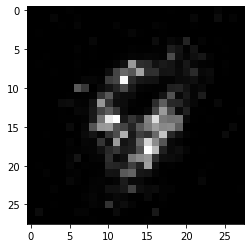

In [209]:
plt.imshow(generated_img.reshape(28,28), cmap='gray')